# Multi-Data set fit using lmfit Package

# Introduction

## The math problem
We have this series time-resolved IR spectra, which is believed to be constructed from a series of Gaussian/Voigt peaks. We can construct a 'vector basis', where all possible peaks are included. Through non-linear regression fittings, such 'vector space' should be able to describe the behavior of the IR spectra at all times. In addition to that, it is believed that some of the peaks within the vector space are intercorrelated, that is, they represent different modes from a same species, hence their ratio at different times should be fixed. With these contraints in mind, we would like to construct an algorithm that could reveal the evolution of different surface species with respect to time. 

The first step would be to try to describe the problem mathematically. 

We have $n$ surface species, each consists of one or more peaks, it could have different vibrational modes in the region of interest. To describe such a surface species mathematically, we have: 

$S_i = \sum_j\alpha_j F(\mu,\sigma)$

, where i is the index of different surface species, and j is the index of peaks from each species. $\alpha_j$ is the amplitute of each independent peak, and $F$ is either a Gaussian, or Voigt, which is defined by both the peak position $\mu$, and peak variance $\sigma$.

Then, we need to assign a total number surface species, usually n = 3, 4, or 5 and we can construct a vector space. 

$X = \{S_0, S_1, S_2, ...\}$

We can use the most basic linear regression to fit the time-resolved spectra with the vector space we just constructed. The math of this step quite simple and well-established. 

$\vec{y} = \vec{\omega}\vec{X} + b$

, here y is a series of spectra, so techniquely this is a multi-output regression. Still the optimization of the hyperparameters are restricted by the minizing the error function: 

$e((\alpha, \mu, \sigma), \omega) = \sum_i \frac{(\vec{y_i} - \vec{y_{model,i}})^2}{len(\vec{y_i})}$

## Define fitting functions

In [1]:
import matplotlib.pyplot as plt
from scipy import special
import numpy as np
from lmfit import minimize, Parameters, report_fit, Minimizer
from lmfit.models import GaussianModel, VoigtModel
import seaborn as sns
import time
import pandas as pd
from ipynb.fs.full.functions import get_first_nbr_from_str, baseline_als

In [2]:
from ipynb.fs.full.functions import Voigt, Gaussian
from ipynb.fs.full.functions import Generate_data, Generate_params, loss_func, Plot_data, Plot_com_data, Print_var
from ipynb.fs.full.functions import Generate_Vec_IG, Generate_data_IG, loss_func_IG, Generate_params_IG, Plot_data_IG

# Test on the real data set

## Import data
Import data from '20200914_cleaned.xlsx'. Import the difference data and accumulation data.

30.0
40.0
50.0
60.0
120.0
480.0
The fitted region started at 2790.535 cm-1, and ended at 2981.457 cm-1.


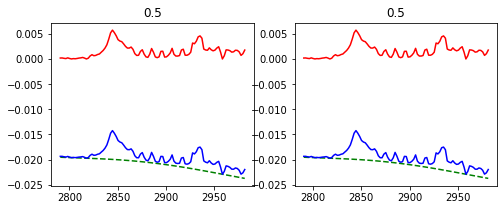

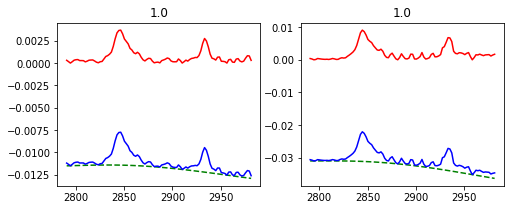

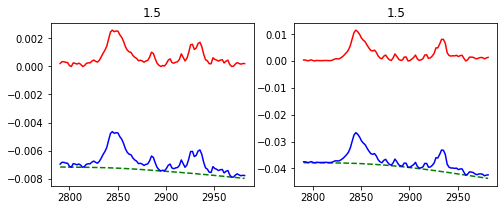

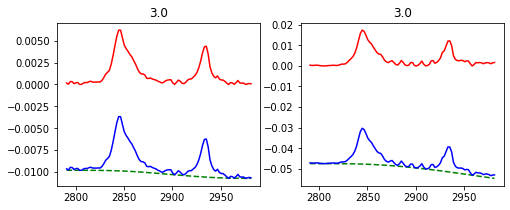

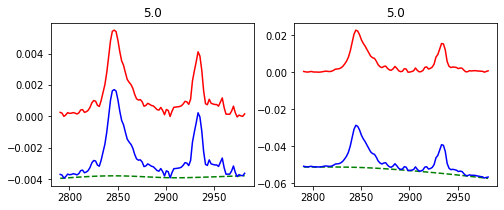

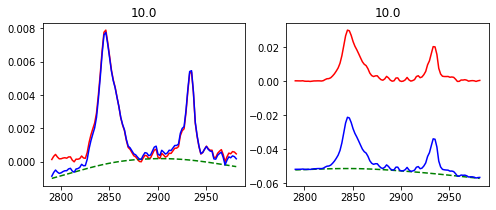

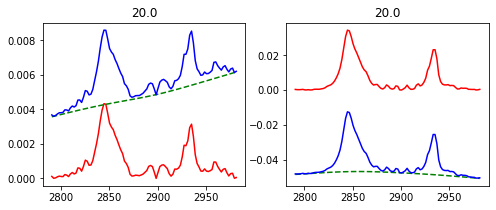

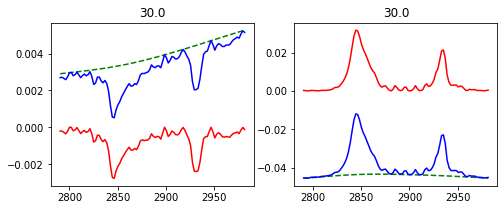

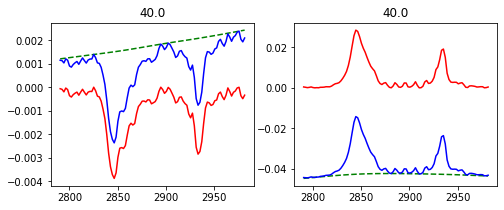

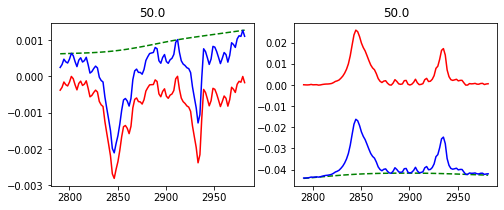

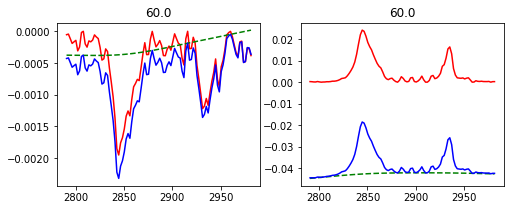

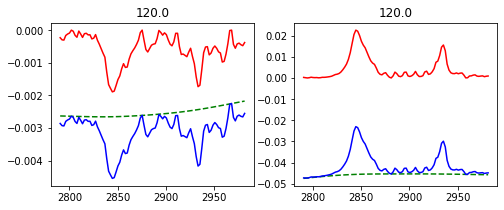

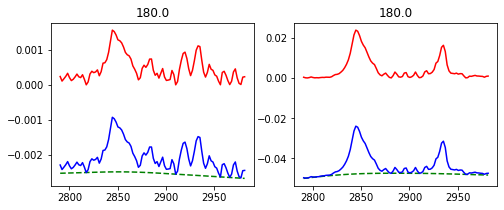

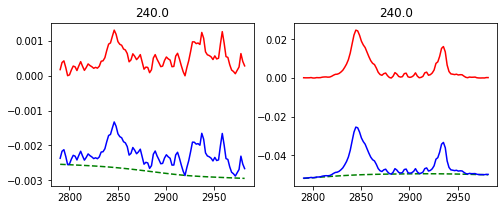

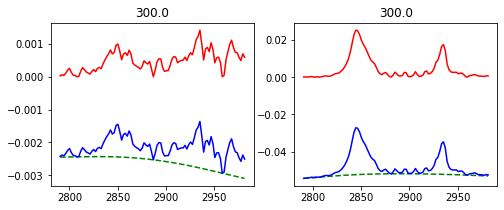

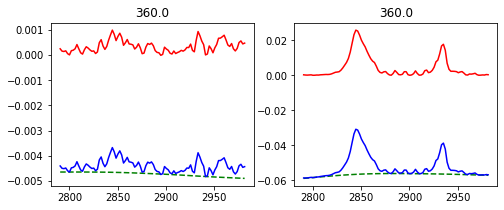

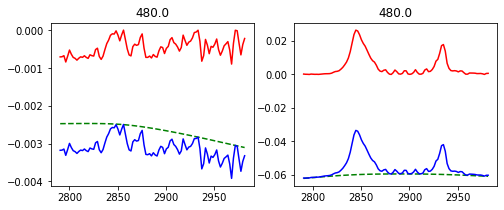

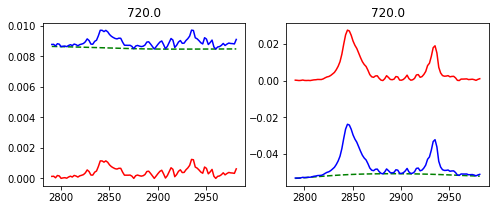

In [212]:
df = pd.read_excel (r'20201107.xlsx')
column_num = np.shape(df)[1]
sns.color_palette(n_colors = column_num)
ratio = 1.15
INR = 1       #index of reference spectrum

###accumulation and differences
dif = pd.DataFrame(df,columns = [df.columns[0]])
acu = pd.DataFrame(df,columns = [df.columns[0]])
CDF = 0.004 

for i in range(INR+1,column_num):
    if i == INR+1:
        dif[df.columns[i]] = df[df.columns[i]] - df[df.columns[INR]]*ratio
        acu[df.columns[i]] = dif[df.columns[i]]
    else:
        dif[df.columns[i]] = df[df.columns[i]] - df[df.columns[i-1]]
        acu[df.columns[i]] = acu[df.columns[i-1]] + dif[df.columns[i]]       



column_num_new = np.shape(dif)[1]
SCH = 1240     #start index of CH 
ECH = 1340     #end index of CH
a = np.transpose(acu[[dif.columns[0]]][SCH:ECH].to_numpy())
WN = a[0]
CH_acu = []
CH_dif = []
time_CH = np.zeros(column_num_new-1)

for i in range(1,column_num_new):
    time_CH[i-1] = get_first_nbr_from_str(dif.columns[i])
    a = np.transpose(dif[[dif.columns[i]]][SCH:ECH].to_numpy())
    a = a[0]
    ##baseline correction
    if a[38] < a[0]:
        print(get_first_nbr_from_str(dif.columns[i]))
        b = -a
        bsl = baseline_als(b, 105, 0.0001)
        y = -(b - bsl)
        bsl = -bsl
    else:
        bsl = baseline_als(a, 105, 0.0001)
        y = a - bsl

    
    a_acu = np.transpose(acu[[dif.columns[i]]][SCH:ECH].to_numpy())[0]
    bsl_acu = baseline_als(a_acu, 105, 0.0001)
    y_acu = a_acu-bsl_acu
    CH_dif.append(y)
    CH_acu.append(y_acu)
    time_CH[i-1] = get_first_nbr_from_str(dif.columns[i])
    fig,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].plot(WN,y,'r')
    ax[0].plot(WN,bsl,'g--')
    ax[0].plot(WN,a,'b')
    ax[0].set_title(time_CH[i-1])
    ax[1].plot(WN,y_acu,'r')
    ax[1].plot(WN,bsl_acu,'g--')
    ax[1].plot(WN,a_acu,'b')
    ax[1].set_title(time_CH[i-1]) 
print('The fitted region started at {0} cm-1, and ended at {1} cm-1.'.format(WN[0], WN[-1]))
x_CH = np.array(WN)
y_CH = np.array(CH_acu)

In [4]:
column_num_new = np.shape(dif)[1]
S = 455
E = 675
b = np.transpose(dif[[dif.columns[0]]][S:E].to_numpy())
WN = b[0]
CC = []
CC_acu = []
Time = []
for i in range(1,column_num_new):
    a = np.transpose(dif[[dif.columns[i]]][S:E].to_numpy())
    b = np.transpose(acu[[dif.columns[i]]][S:E].to_numpy())
    CC.append(a[0])
    CC_acu.append(b[0])
    Time.append(get_first_nbr_from_str(dif.columns[i]))
x_CC = np.array(WN)
y_CC = np.array(CC)
Time = np.array(Time)
print('The fitted region started at {0} cm-1, and ended at {1} cm-1.'.format(WN[0], WN[-1]))

The fitted region started at 1276.665 cm-1, and ended at 1699.006 cm-1.


1160.955


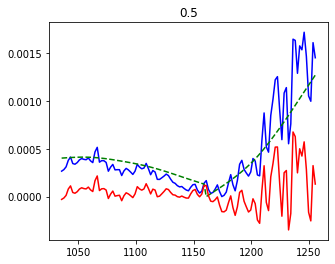

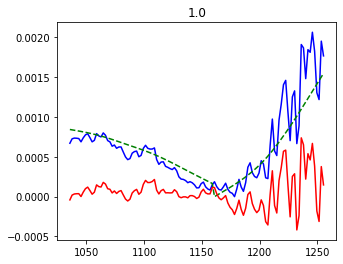

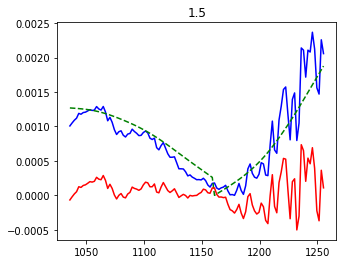

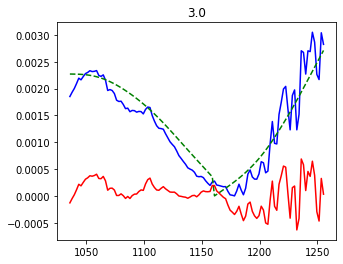

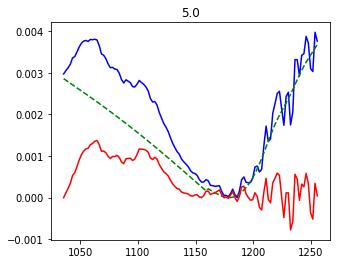

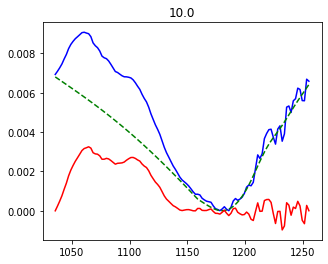

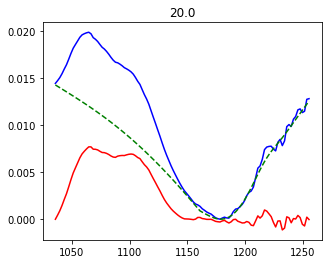

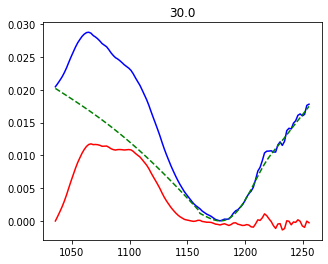

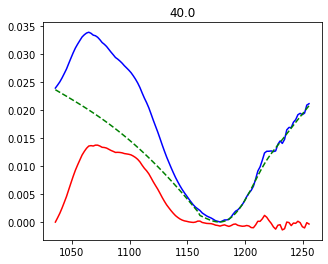

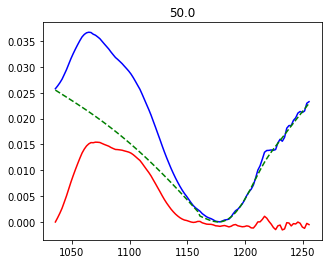

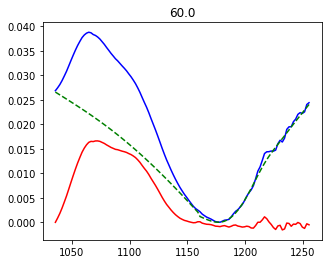

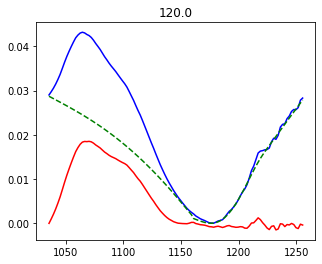

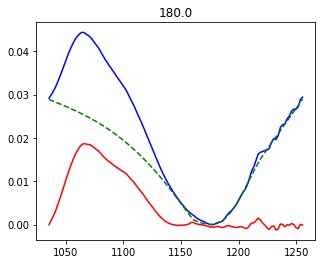

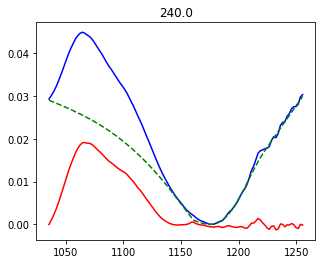

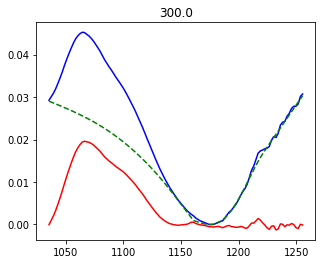

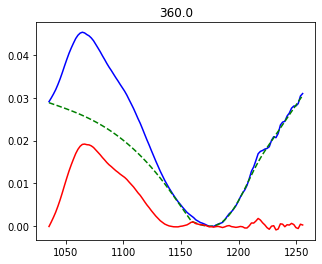

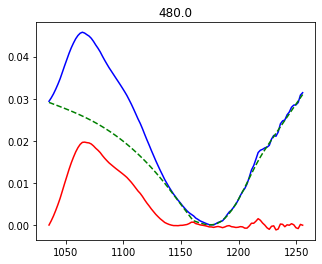

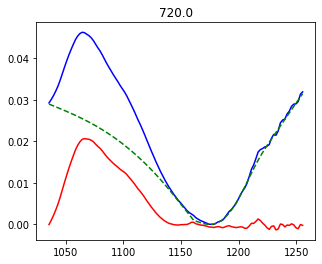

In [140]:
column_num_new = np.shape(dif)[1]
SCO = 330
ECO = 445
LCO = ECO-SCO
b = np.transpose(dif[[dif.columns[0]]][SCO:ECO].to_numpy())
WN = b[0]
CO = []
Min_ind = 65
print(WN[Min_ind])
for i in range(1,column_num_new):
    a = np.transpose(acu[[dif.columns[i]]][SCO:ECO].to_numpy())
    a1 = a[0][:Min_ind]
    a2 = a[0][Min_ind:]
    if i < 5:
        bsl1 = baseline_als(a1, 1005, 0.05)
        bsl2 = baseline_als(a2, 1005, 0.05)
    else: 
        bsl1 = baseline_als(a1, 85,0.00005)
        bsl2 = baseline_als(a2, 105, 0.5)
    y1 = a1 - bsl1
    y2 = a2 - bsl2
    DIF = y1[-1] - y2[0]
    y2 = y2 + DIF
    y = np.concatenate((y1,y2))
    bsl = np.concatenate((bsl1,bsl2))

    CO.append(y)
    fig = plt.figure(figsize=(5,4))
    plt.plot(WN,a[0]-a[0].min(),'b-')
    plt.plot(WN,bsl-bsl.min(),'g--')
    plt.plot(WN,CO[-1],'r-')
    plt.title(time_CH[i-1])

x_CO = np.array(WN)
y_CO = np.array(CO)

## Finding a good initial guess

By implementing the lmfit package, we can performance the optimzation of our loss function by minimizing the least square of the difference between the model and actual data. The 'leastsq' method from the lmfit package uses the 'Levenberg-Marquardt' algorithm for the minization. While often criticized, including the fact it finds
a local minima, this approach has some distinct advantages. These include being fast, and well-behaved for most
curve-fitting needs, and making it easy to estimate uncertainties for and correlations between pairs of fit variables. Still the disadvantage of the 'Levenberg-Marquardt' algorithm which is its looking for local minima should be addressed. Hence, the first step in our modeling methodology is finding a reasonable initial guess so that further optimization would have better performances. 

## Fitting the C-H vibrations

In [213]:
Vec_IG = {'Mus':np.array([2861.9,2952,2853.1,2934.2]),
          'Sigmas':np.array([6.7,3.6,4.1,2.9]),
          'Types':np.array([1,1,1,1]),
          'Fixed':None,
          'Lims':None}

In [214]:
t0 = time.time()
fit_params_IG = Generate_params_IG(x_CC,Vec_IG,ndata =18)

fitter = Minimizer(loss_func_IG, fit_params_IG, fcn_args=(x_CH, y_CH, Vec_IG))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 95.19733309745789


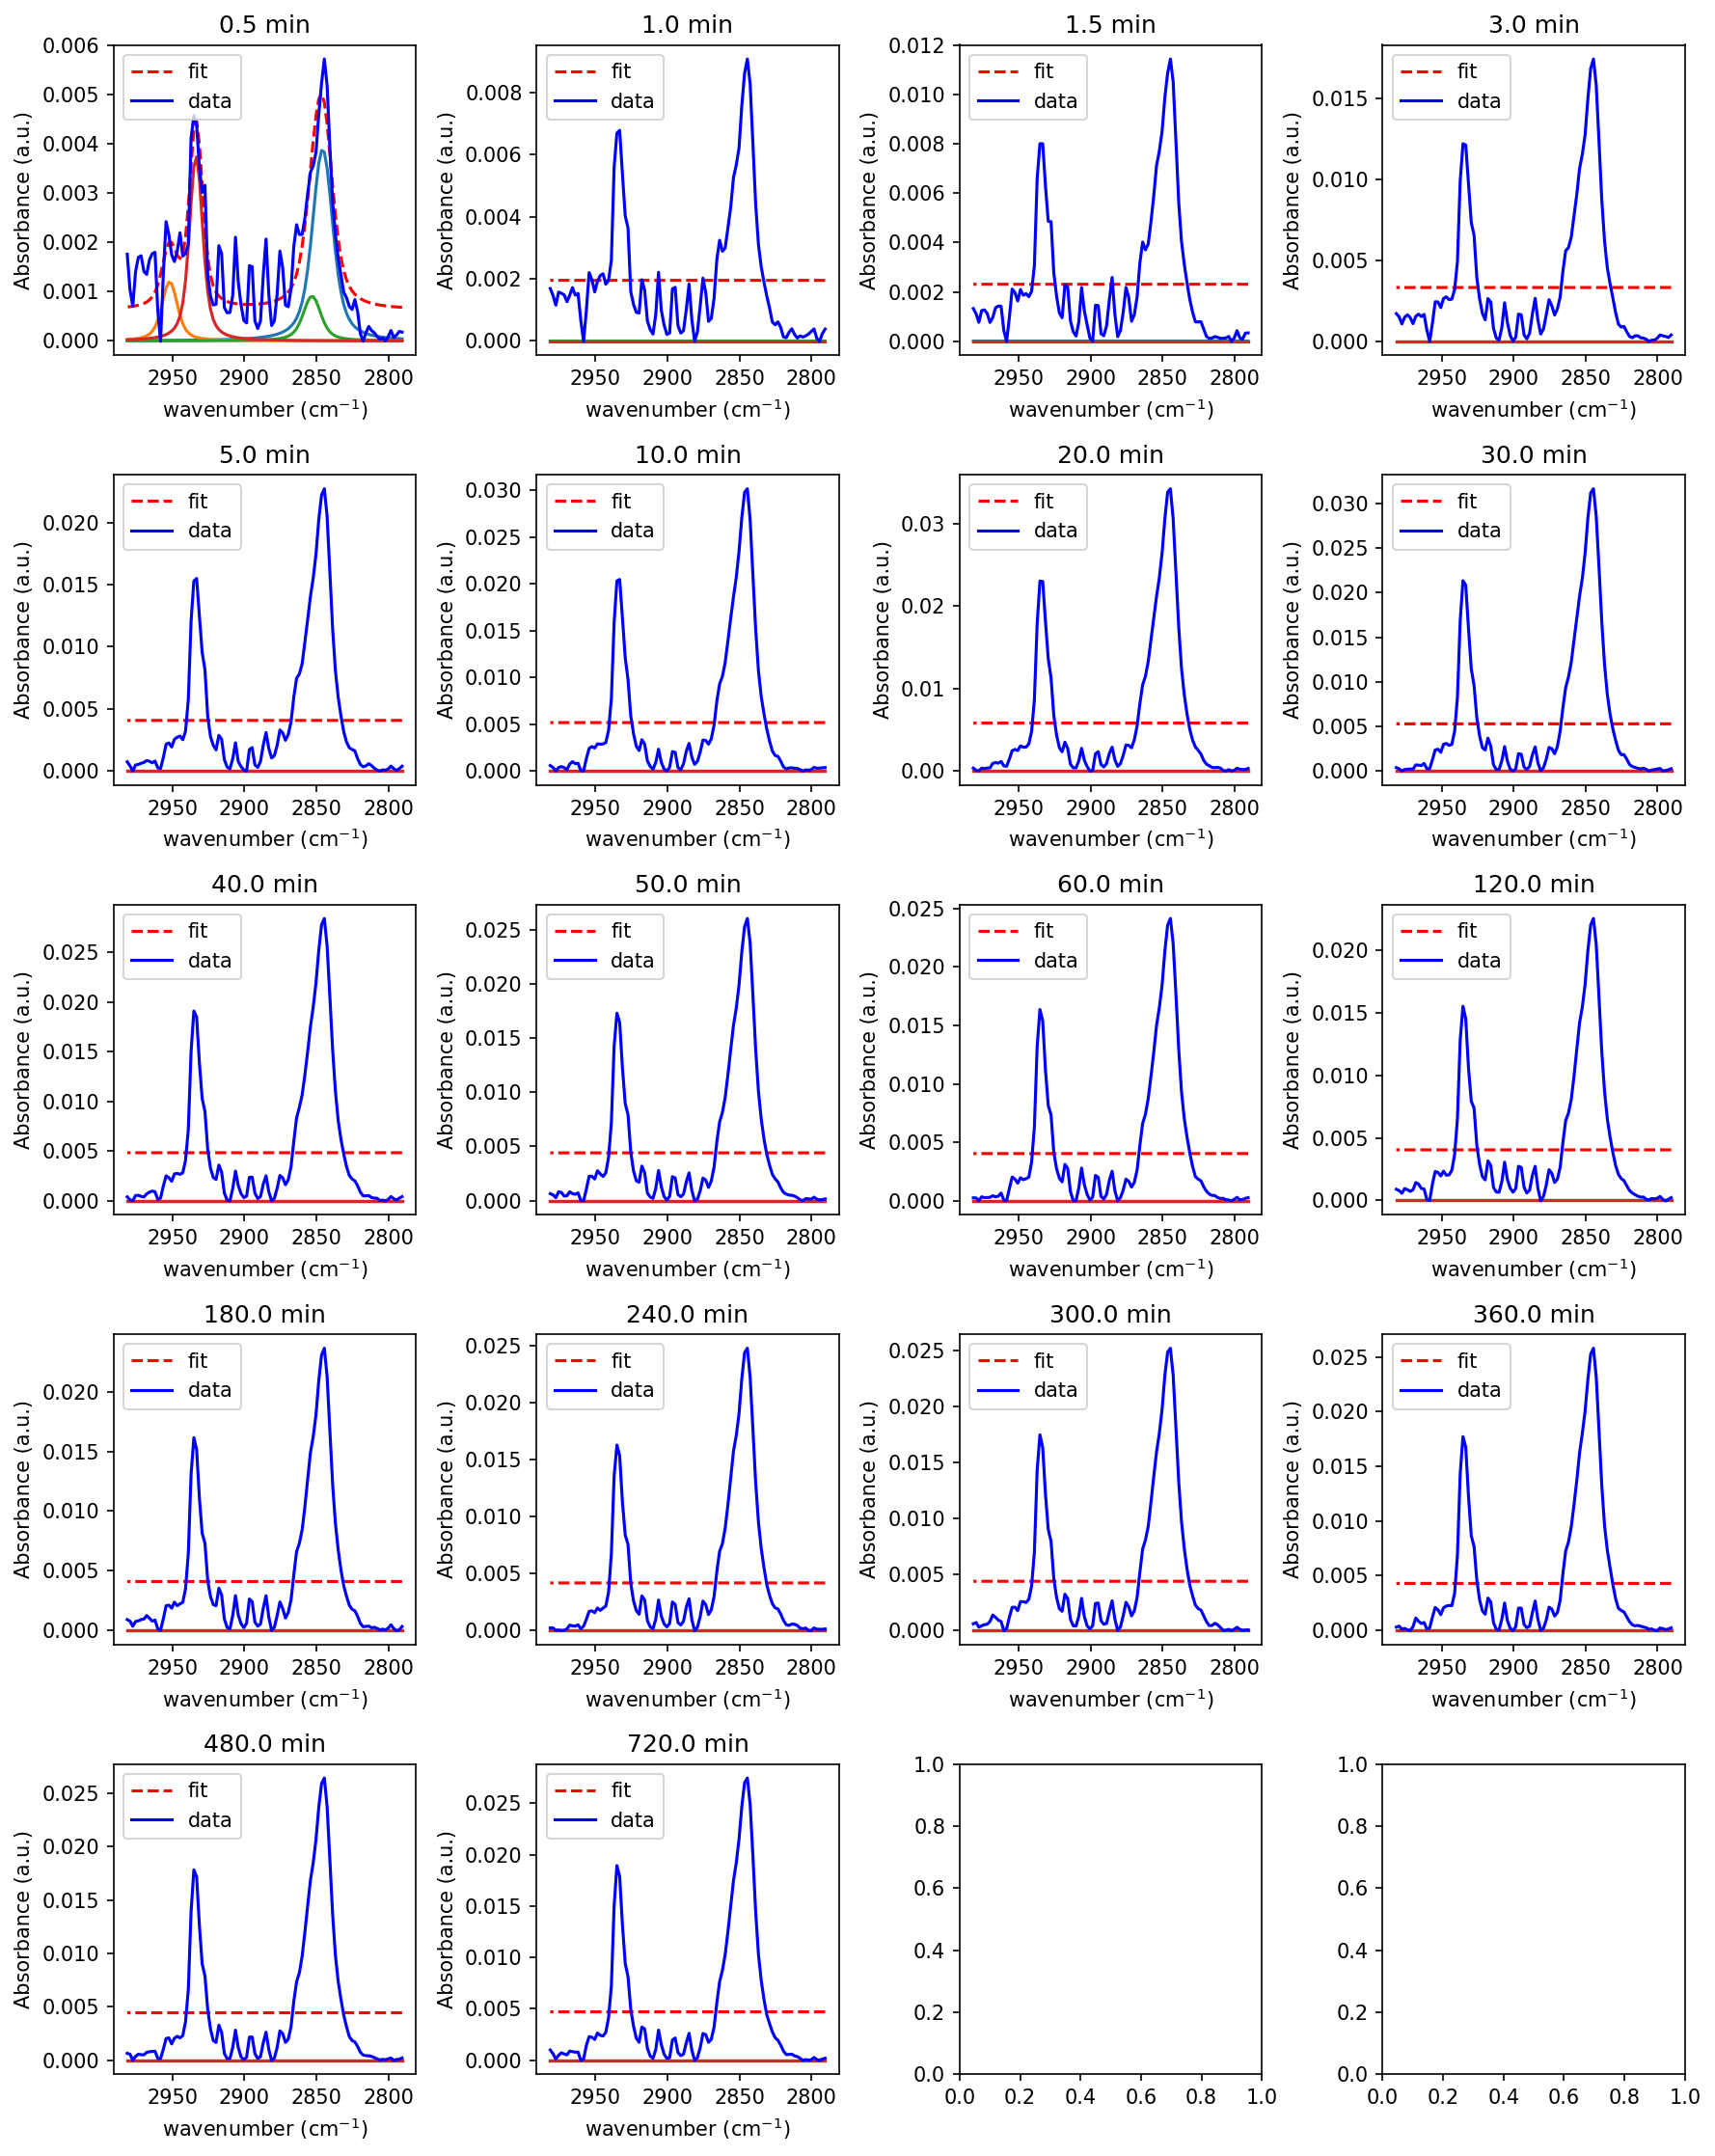

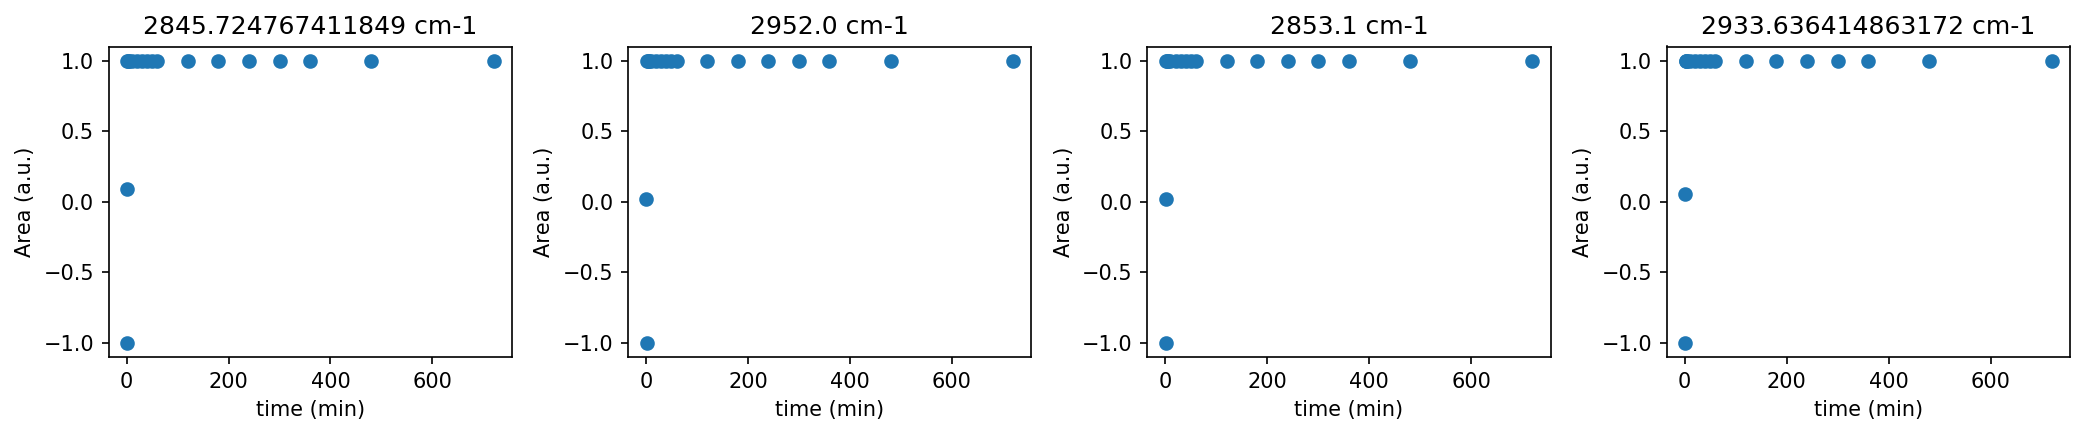

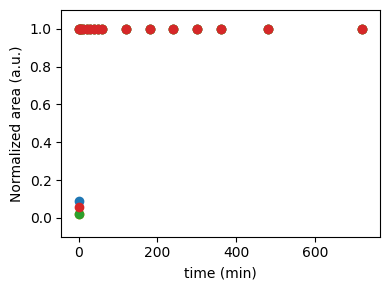

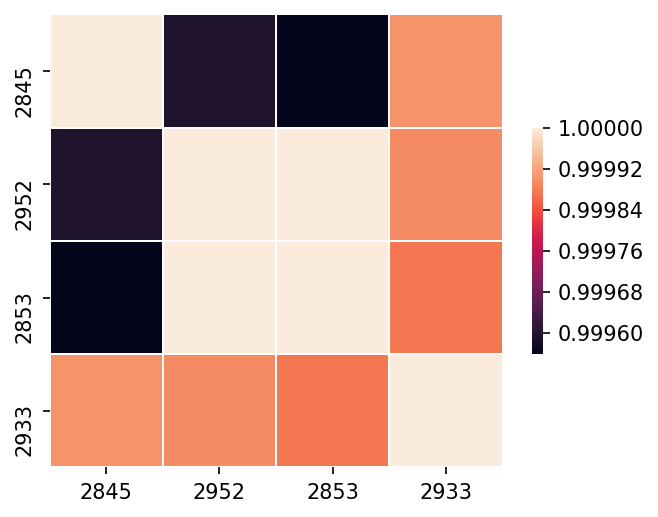

{'Peak Pos': [2845, 2952, 2853, 2933],
 'Amps': array([[ 0.08742127,  0.02070069,  0.01781946,  0.0550314 ],
        [-1.        , -1.        , -1.        , -1.        ],
        [ 0.99999976,  0.99999989,  0.99999995,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  0.99999134],
        [ 1.        ,  1.        ,  1.        ,  0.9999998 ],
        [ 1.        ,  1.        ,  1.        ,  0.99999997],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  

In [216]:
params_IG = result.params
Plot_data_IG(params_IG,x_CH,y_CH,Vec_IG,time_CH[:18],False)

In [217]:
Vec_IG_struc = {'Peaks':[[0,1,2,3]],'Types':[[1,1,1,1]]}

Vec_fit = Generate_Vec_IG(params_IG,Vec_IG_struc,18)
Vec_fit['Alphas']= None
Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
                           'Specs':np.array([[2845,2845,2845,2845],
                                            [4000,4000,4000,4000],
                                            [3.1,.1,3.1,0.1],
                                            [8,6.5,4.5,6.5],
                                            [0,0,0,0]])}
print(Vec_fit)

{'Vec0': {'Mus': array([2845.72476741, 2952.        , 2853.1       , 2933.63641486]), 'Sigmas': array([4.69000002, 3.6       , 4.1       , 3.06130307]), 'Amps': array([0.83819006, 0.83448337, 0.8343233 , 0.83639014]), 'Types': [1, 1, 1, 1], 'Lims': {'Peaks': array([0, 1, 2, 3]), 'Specs': array([[2.845e+03, 2.845e+03, 2.845e+03, 2.845e+03],
       [4.000e+03, 4.000e+03, 4.000e+03, 4.000e+03],
       [3.100e+00, 1.000e-01, 3.100e+00, 1.000e-01],
       [8.000e+00, 6.500e+00, 4.500e+00, 6.500e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])}}, 'Alphas': None}


In [218]:
t0 = time.time()
fit_params = Generate_params(x_CH,Vec_fit,ndata = 18)

fitter = Minimizer(loss_func, fit_params, fcn_args=(x_CH, y_CH, Vec_fit))
result = fitter.minimize(method='leastsq')
t1 = time.time()

print('The time cost is:',t1-t0)

0 4.690000015455019 3.1 8.0
0 2845.724767411849 2845.0 2875.724767411849
0 3.6 0.1 6.5
0 2952.0 2922.0 2982.0
0 4.1 3.1 4.5
0 2853.1 2845.0 2883.1
0 3.0613030724384824 0.1 6.5
0 2933.636414863172 2903.636414863172 2963.636414863172
The time cost is: 19.670648097991943


In [219]:
new_params = result.params
report_fit(new_params)

[[Variables]]
    lin_0:     7.6586e-04 (init = 0)
    amp_000:   0.03257496 (init = 0.08381901)
    cen_000:   2856.71224 (init = 2845.725)
    sig_000:   4.34401092 (init = 4.69)
    amp_001:   0.00245959 (init = 0.08344834)
    cen_001:   2951.80236 (init = 2952)
    sig_001:   2.04721404 (init = 3.6)
    amp_002:   0.07657772 (init = 0.08343233)
    cen_002:   2845.00000 (init = 2853.1)
    sig_002:   3.74702680 (init = 4.1)
    amp_003:   0.04119960 (init = 0.08363901)
    cen_003:   2933.79435 (init = 2933.636)
    sig_003:   2.76180073 (init = 3.061303)
    lin_1:     6.2856e-04 (init = 0)
    amp_100:   0.05587808 (init = 0.08381901)
    cen_100:   2856.71224 == 'cen_000'
    sig_100:   4.34401092 == 'sig_000'
    amp_101:   0.00421910 == 'amp_100*amp_001/amp_000'
    cen_101:   2951.80236 == 'cen_001'
    sig_101:   2.04721404 == 'sig_001'
    amp_102:   0.13135905 == 'amp_100*amp_002/amp_000'
    cen_102:   2845.00000 == 'cen_002'
    sig_102:   3.74702680 == 'sig_002'
    am

Plotting.....


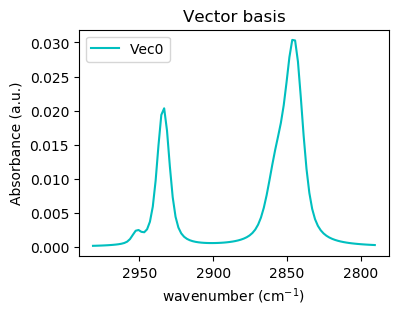

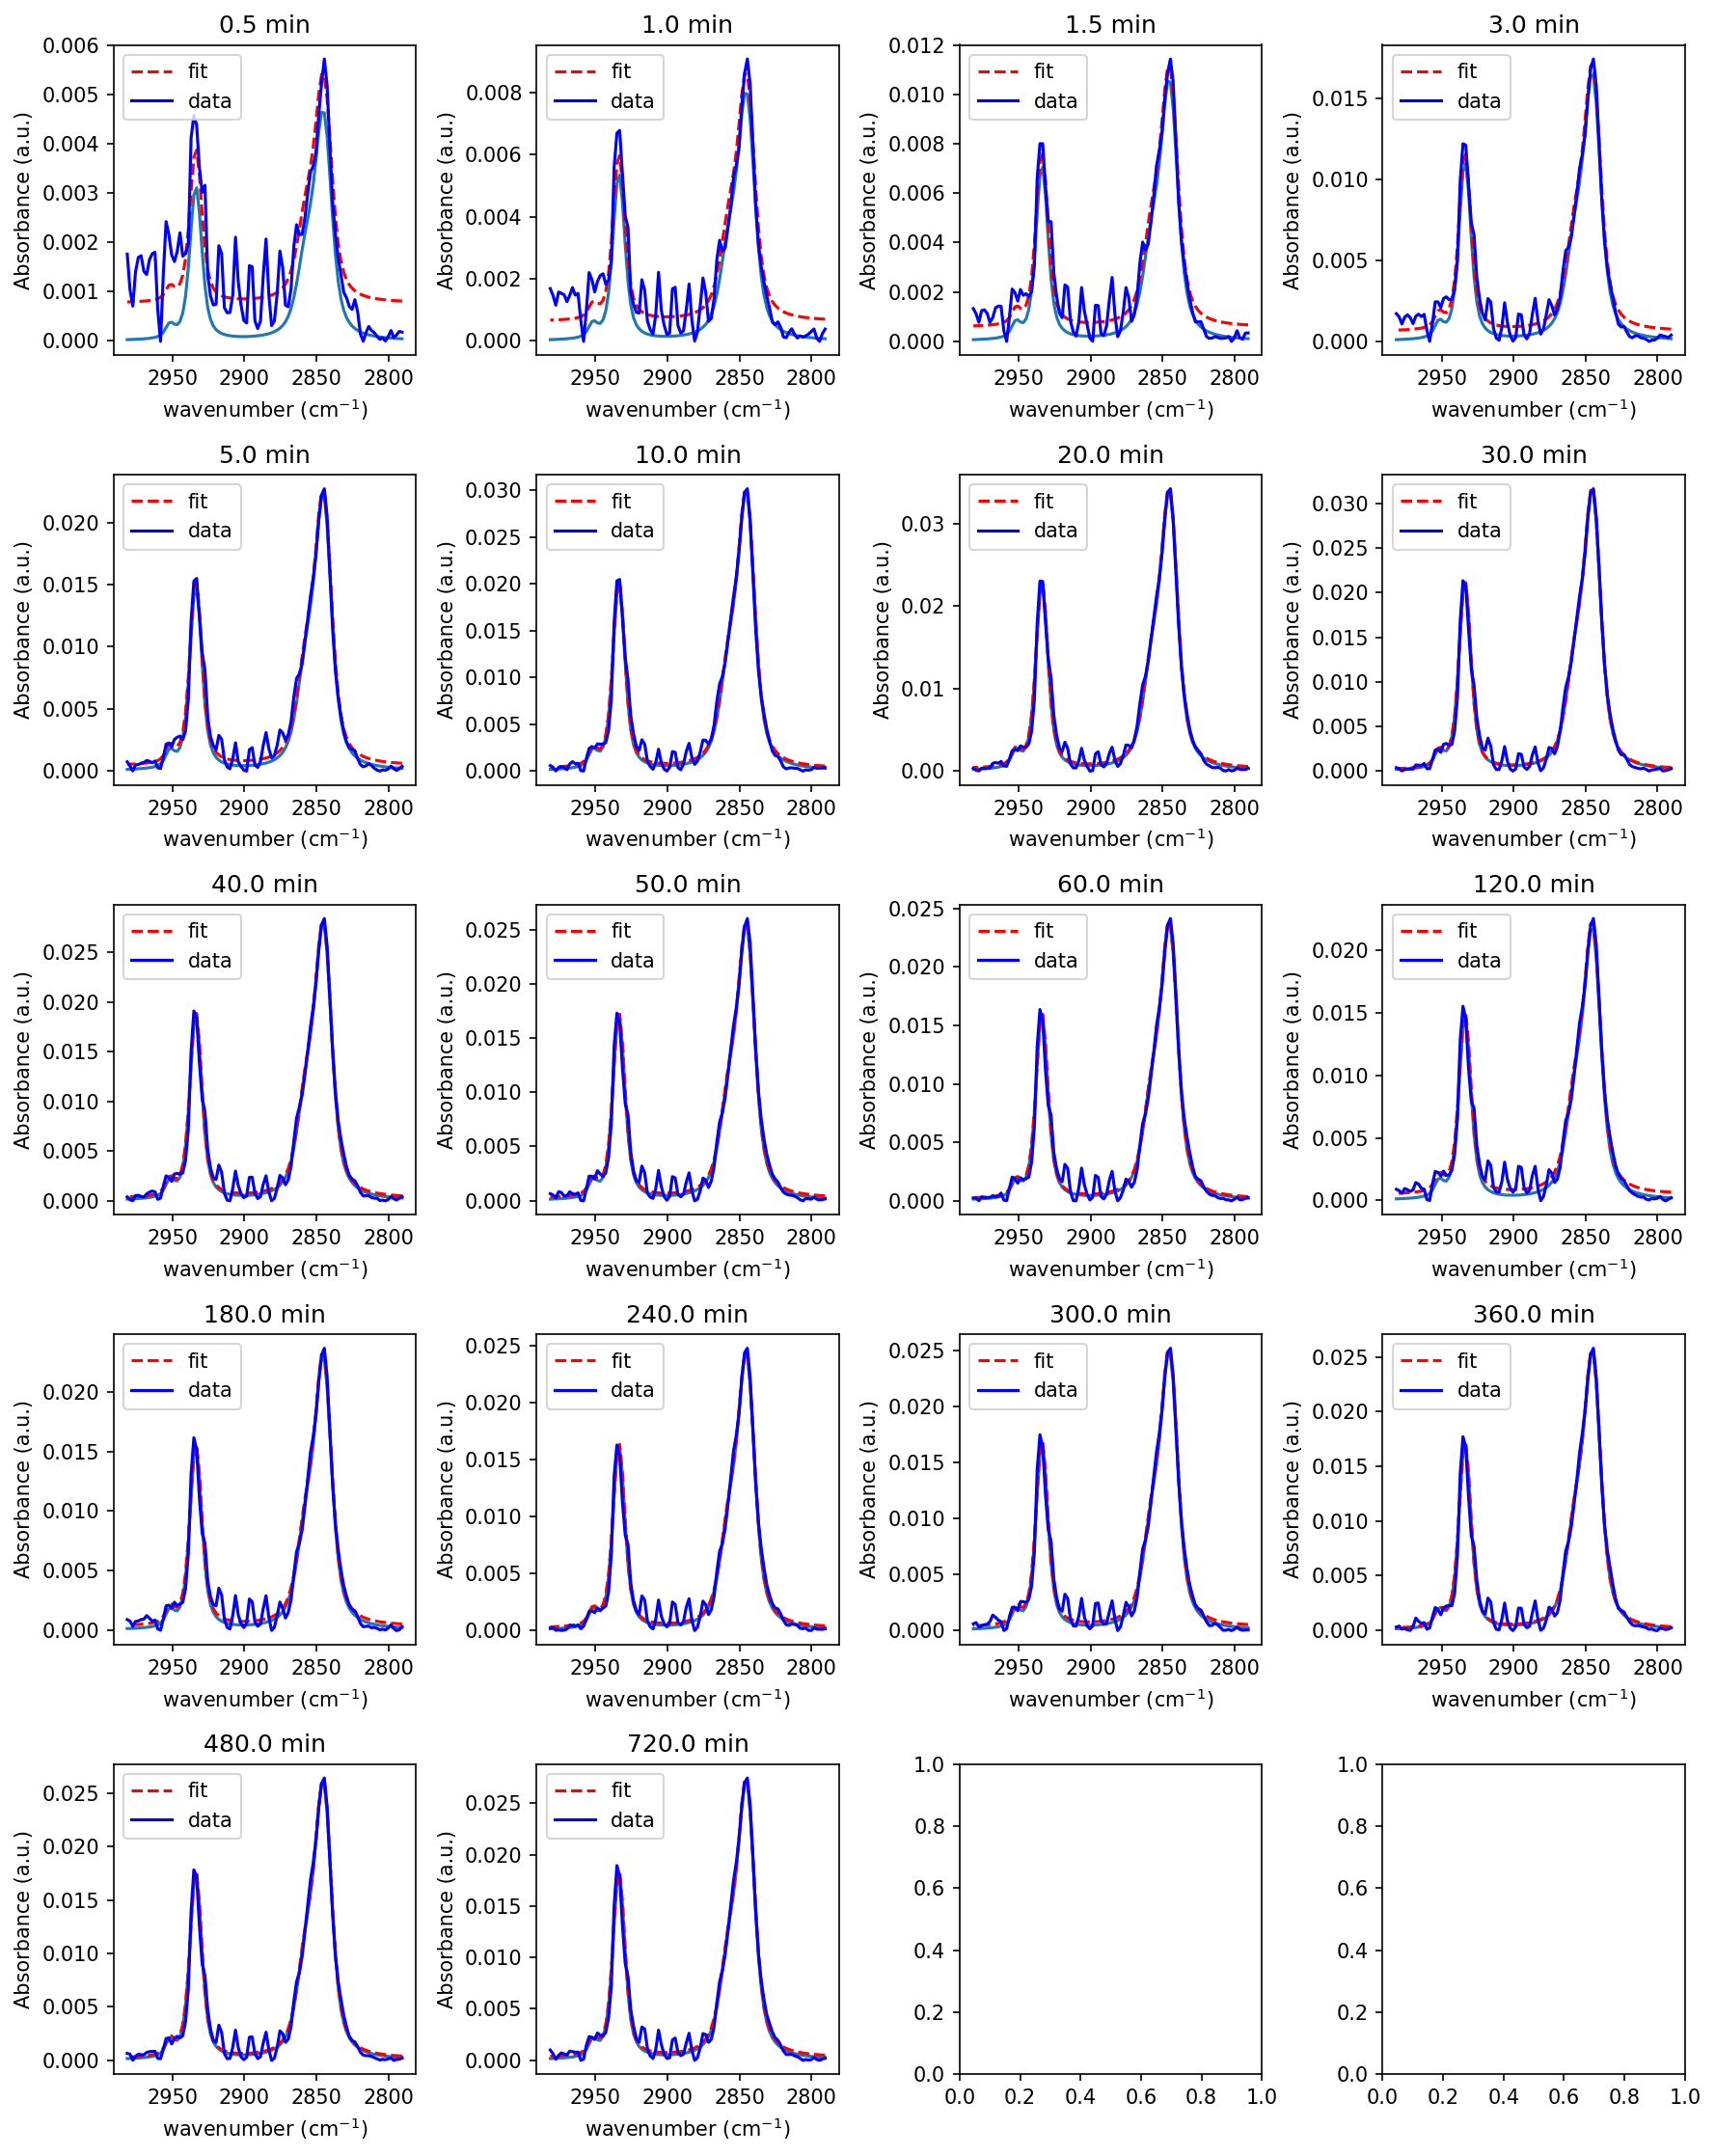

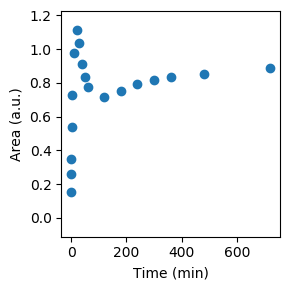

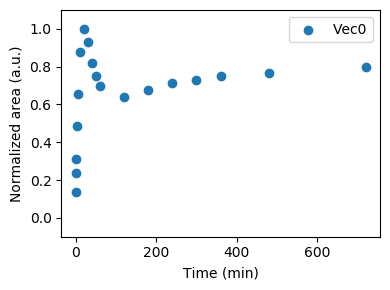

In [220]:
Plot_data(new_params,x_CH,y_CH,Vec_fit,time_CH[:18],False)

## Fitting the 1300-1700 cm$^{-1}$ region

We want to include a peak around 1600 cm$^{-1}$ as the C=O species, two peaks around 1540 cm$^{-1}$ for carbonates, 4 peaks around 1300 cm$^{-1}$ to 1500 cm$^{-1}$ for aromatics and finally, a two peaks around 1350 cm$^{-1}$ for the formates.

We wanna repeat the previous procedure, i.e.:

    1) Make an initial guess on all the peaks
    2) Group the peaks and creat a vector space
    3) Use the new vector basis to perform non-linear regression fit for optimization of the parameters
   


### Fitting the initial stage (0,10) min

We use postfix _CC0 for fitting of this period.

Below is an intial guess of the peaks.

In [32]:
Vec_IG_CC0 = {'Mus':np.array([1580.5,1544.5,1548.3,1488.25,1424.5, 1349.9,1371.1,1357.8,1304]),
             'Sigmas':np.array([10,3.624,17.8,13.4,17.9, 22.9,1.764,4.375,2]),
             'Types':np.array([1,0,1,1,1,1,0,0,0]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':True,
                     'Mus_min':np.array([1590,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}             
             }


In [33]:
t0 = time.time()
ndata = 6
fit_params_IG = Generate_params_IG(x_CC,Vec_IG_CC0,ndata = ndata)
fitter = Minimizer(loss_func_IG, fit_params_IG, fcn_args=(x_CC, y_CC[:ndata], Vec_IG_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)


The time cost is: 10.559432029724121


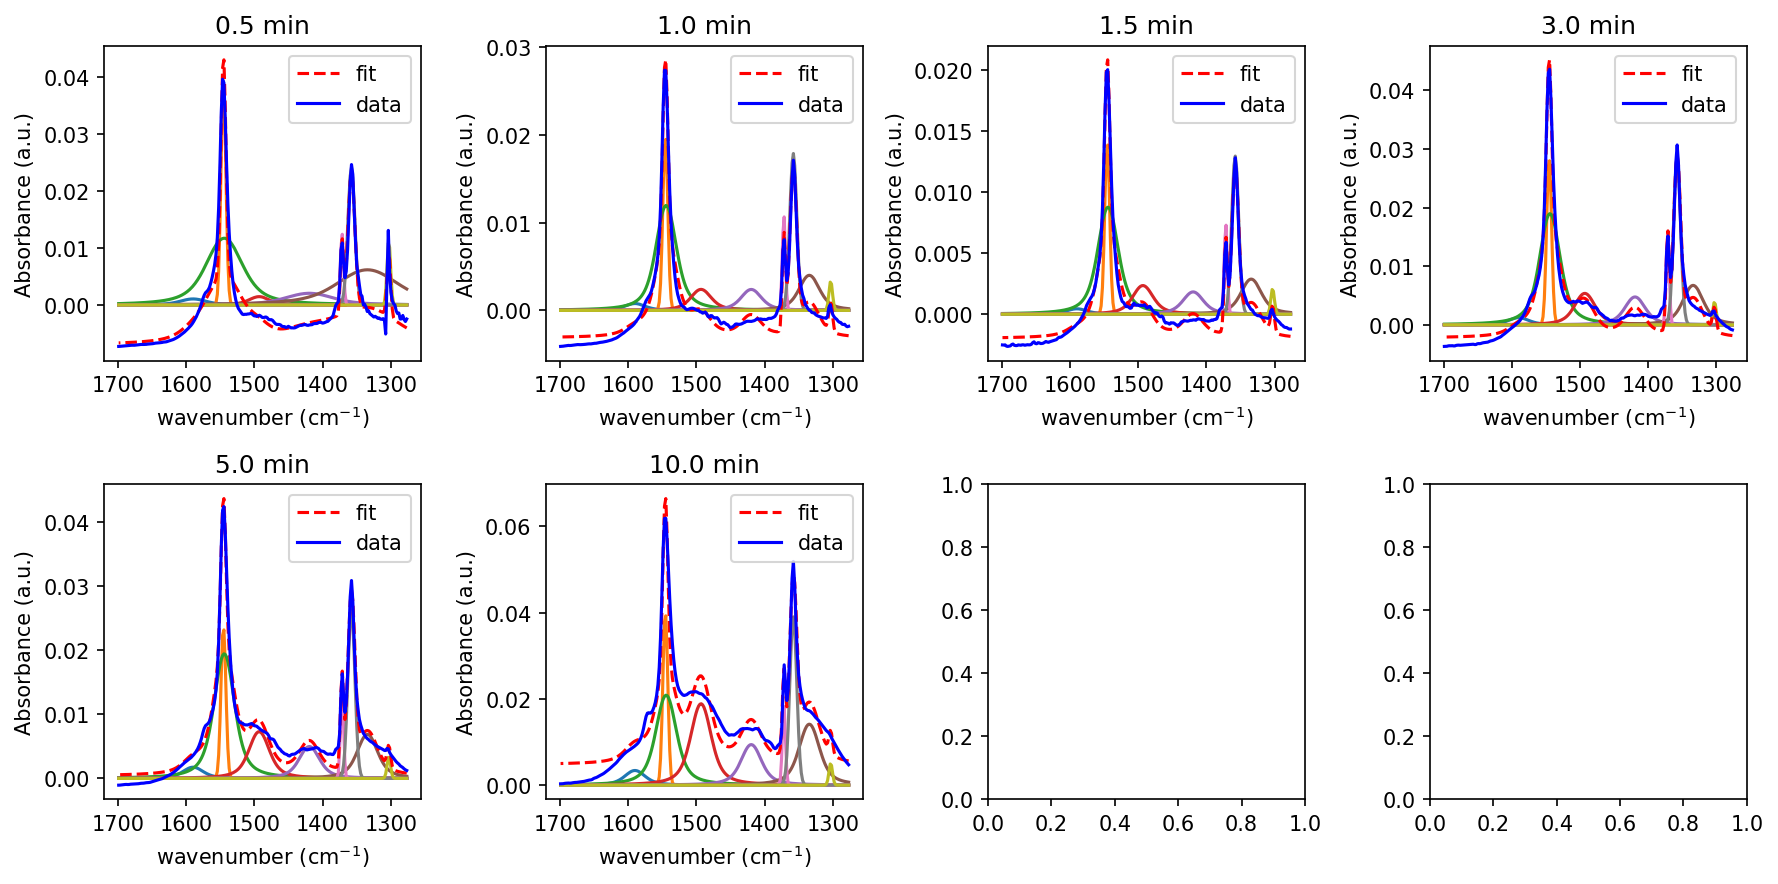

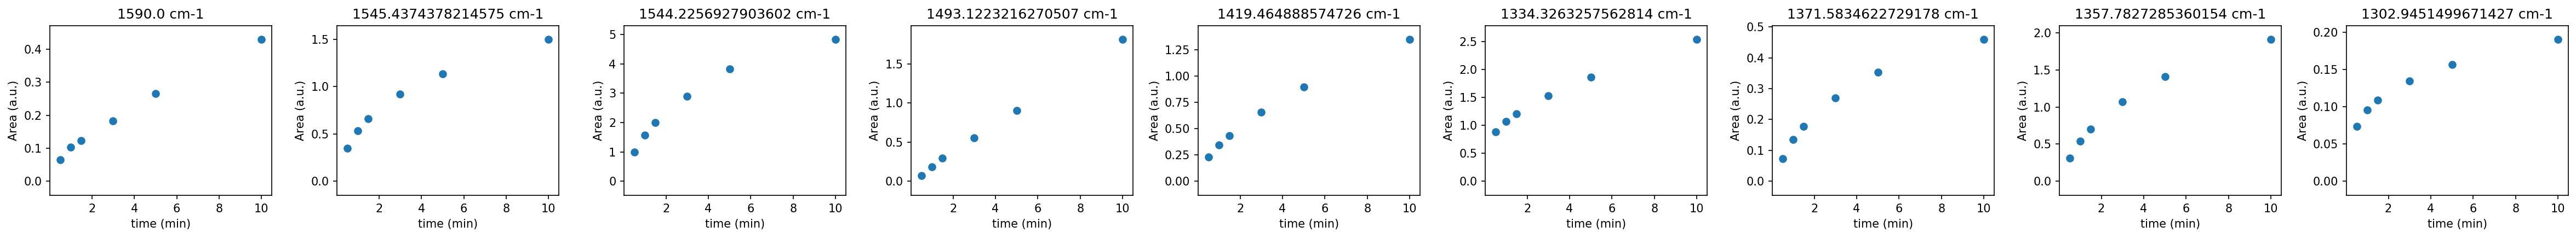

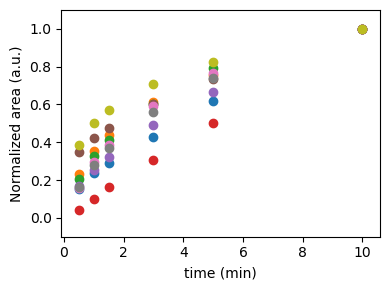

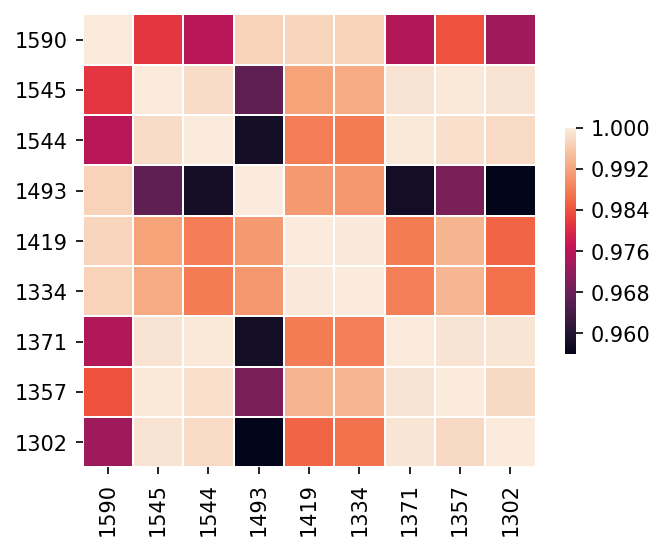

{'Peak Pos': [1590, 1545, 1544, 1493, 1419, 1334, 1371, 1357, 1302],
 'Amps': array([[0.06521266, 0.34994772, 0.99985863, 0.07017996, 0.22925468,
         0.88144997, 0.07259959, 0.30955414, 0.0734674 ],
        [0.10260824, 0.53016031, 1.57219657, 0.1848582 , 0.34353018,
         1.07289202, 0.13481475, 0.538747  , 0.09523869],
        [0.12385384, 0.65844147, 1.99222481, 0.29731603, 0.43105795,
         1.21068277, 0.17742839, 0.704957  , 0.10891207],
        [0.18282961, 0.91751501, 2.90068699, 0.55454083, 0.65907725,
         1.53330771, 0.2706353 , 1.07269028, 0.13460145],
        [0.26656172, 1.13169129, 3.83056773, 0.90355996, 0.89713253,
         1.86196913, 0.35263766, 1.40972729, 0.15670619],
        [0.4295228 , 1.49543122, 4.83046348, 1.80840074, 1.34819112,
         2.54002887, 0.45914481, 1.91074422, 0.18998309]])}

In [34]:
params_IG = result.params
Plot_data_IG(params_IG,x_CC,y_CC[:ndata],Vec_IG_CC0,time_CH[:ndata],True)

Now we want to creat a frame of the vector space, i.e. we need to define how many vectors are there and which peaks belong to which vector.

In [35]:
Vec_IG_CC0 = {'Peaks':np.array([[0],[1,2],[3,4,5],[6,7],[8]]),
              'Types':np.array([[1],[0,1],[1,1,1],[0,0],[0]])}
Vec_fit_CC0 = Generate_Vec_IG(params_IG,Vec_IG_CC0,ndata)
#Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
#                           'Specs':np.array([[0.1,0.1,0.1,0.1],
#                                            [4000,4000,4000,4000],
#                                            [0.1,.1,0.1,0.1],
#                                            [6.5,6.5,6.5,6.5]])}


In [36]:
def Generate_params(x,Vec,ndata):
    params = Parameters()
    nvec = len(Vec)-1
    if Vec['Alphas'] is None:
        alpha = np.ones((nvec,ndata))*0.1
    else:
        ndata = np.shape(Vec['Alphas'])[1]
        alpha = Vec['Alphas']
    y = np.zeros((ndata,len(x)))
    Min = x.min()
    Max = x.max()
    for i in range(ndata):
        params.add('lin_{}'.format(i), value=0, min=-1, max =1)
        for j in range(nvec):
            npeak = len(Vec['Vec{}'.format(j)]['Mus'])
            if Vec['Vec{}'.format(j)]['Lims'] is None:
                auto = True
            else:    
                auto = False
            for k in range(npeak):
                mu = Vec['Vec{}'.format(j)]['Mus'][k]
                sigma = Vec['Vec{}'.format(j)]['Sigmas'][k]
                if Vec['Vec{}'.format(j)]['Types'][k]:
                    sigma_max_hard = 25.
                    mu_const = 30.
                    sigma_const = 15.
                else: 
                    sigma_max_hard = 6.5
                    mu_const = 5.
                    sigma_const = 5.
                mu_min = mu - mu_const
                mu_max = mu + mu_const
                sigma_min = max(0.1,sigma - sigma_const)
                sigma_max = sigma + sigma_const
                amp_min = -10
                if auto == False: 
                    if k in Vec['Vec{}'.format(j)]['Lims']['Peaks']:
                        index = np.where(Vec['Vec{}'.format(j)]['Lims']['Peaks'] == k)[0][0]
                        mu_min = max(mu_min, Vec['Vec{}'.format(j)]['Lims']['Specs'][0,index])
                        mu_max = min(mu_max, Vec['Vec{}'.format(j)]['Lims']['Specs'][1,index])
                        sigma_min = max(0.1, sigma_min, Vec['Vec{}'.format(j)]['Lims']['Specs'][2,index])
                        sigma_max = min(sigma_max, Vec['Vec{}'.format(j)]['Lims']['Specs'][3,index], sigma_max_hard)
                        amp_min = max(-10, Vec['Vec{}'.format(j)]['Lims']['Specs'][4,index])
                        if 
                if i == 0:
                    amp = Vec['Vec{}'.format(j)]['Amps'][k]*alpha[j,i]
                    print(j,sigma,sigma_min,sigma_max)
                    print(j,mu,mu_min,mu_max)
                    params.add('amp_{}{}{}'.format(i,j,k), value=amp, min=amp_min,  max=10)
                    params.add('cen_{}{}{}'.format(i,j,k), value=mu, min=mu_min,  max=mu_max)
                    params.add('sig_{}{}{}'.format(i,j,k), value=sigma, min=sigma_min,  max=sigma_max)
                else: 
                    if k == 0:
                        amp = Vec['Vec{}'.format(j)]['Amps'][k]*alpha[j,i]
                        params.add('amp_{}{}{}'.format(i,j,k), value=amp, min=-10,  max=10)
                    else:
                        a = params['amp_{}{}{}'.format(i,j,0)].value
                        b = params['amp_{}{}{}'.format(0,j,k)].value
                        c = params['amp_{}{}{}'.format(0,j,0)].value
    
                        amp = a*b/c
                        params.add('amp_{}{}{}'.format(i,j,k), min=-10,  max=10,
                                   expr = 'amp_{}{}{}*amp_{}{}{}/amp_{}{}{}'.format(i,j,0,0,j,k,0,j,0))

                    params.add('cen_{}{}{}'.format(i,j,k), min=mu_min,  max=mu_max, expr='cen_{}{}{}'.format(0,j,k))
                    params.add('sig_{}{}{}'.format(i,j,k), min=sigma_min,  max=sigma_max, expr='sig_{}{}{}'.format(0,j,k))
                if Vec['Vec{}'.format(j)]['Types'][k]:
                    y[i] = y[i] + Voigt(x,amp,mu,sigma)
                else: 
                    y[i] = y[i] + Gaussian(x,amp,mu,sigma)
                #print('{}{}{}\t{}\t{}\t{}'.format(i,j,k,amp,mu,sigma))
    return params

In [39]:
t0 = time.time()
Vec_fit_CC0['Alphas'] = None
Vec_fit_CC0['Vec0']['Lims'] = {'Peaks':np.array([0]),'Specs':np.array([[0],[4000],[0.1],[20],[0]]),'Pos':[True]}
#Vec_fit_CC0['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[0,0],[4000,4000],[1.2,1.2],[4,4],[-10,-10]])}
fit_params_CC0 = Generate_params(x_CC,Vec_fit_CC0,ndata =ndata)

fitter = Minimizer(loss_func, fit_params_CC0, fcn_args=(x_CC, y_CC[:ndata], Vec_fit_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 12.812439240938023 0.1 20.0
0 1590.0 1560.0 1620.0
1 3.624 0.1 8.624
1 1545.4374378214575 1540.4374378214575 1550.4374378214575
1 17.8 2.8000000000000007 32.8
1 1544.2256927903602 1514.2256927903602 1574.2256927903602
2 10.00000922262351 0.1 25.00000922262351
2 1493.1223216270507 1463.1223216270507 1523.1223216270507
2 23.249971034299413 8.249971034299413 38.24997103429941
2 1419.464888574726 1389.464888574726 1449.464888574726
2 29.765453583261802 14.765453583261802 44.7654535832618
2 1334.3263257562814 1304.3263257562814 1364.3263257562814
3 2.29297972025833 0.1 7.29297972025833
3 1371.5834622729178 1366.5834622729178 1376.5834622729178
3 5.119273305979536 0.11927330597953567 10.119273305979537
3 1357.7827285360154 1352.7827285360154 1362.7827285360154
4 2.5999999999966406 0.1 7.5999999999966406
4 1302.9451499671427 1297.9451499671427 1307.9451499671427
The time cost is: 597.9497909545898


The score of the fit is: 0.0013119290823068953
Plotting.....


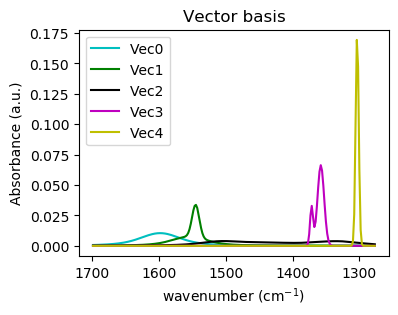

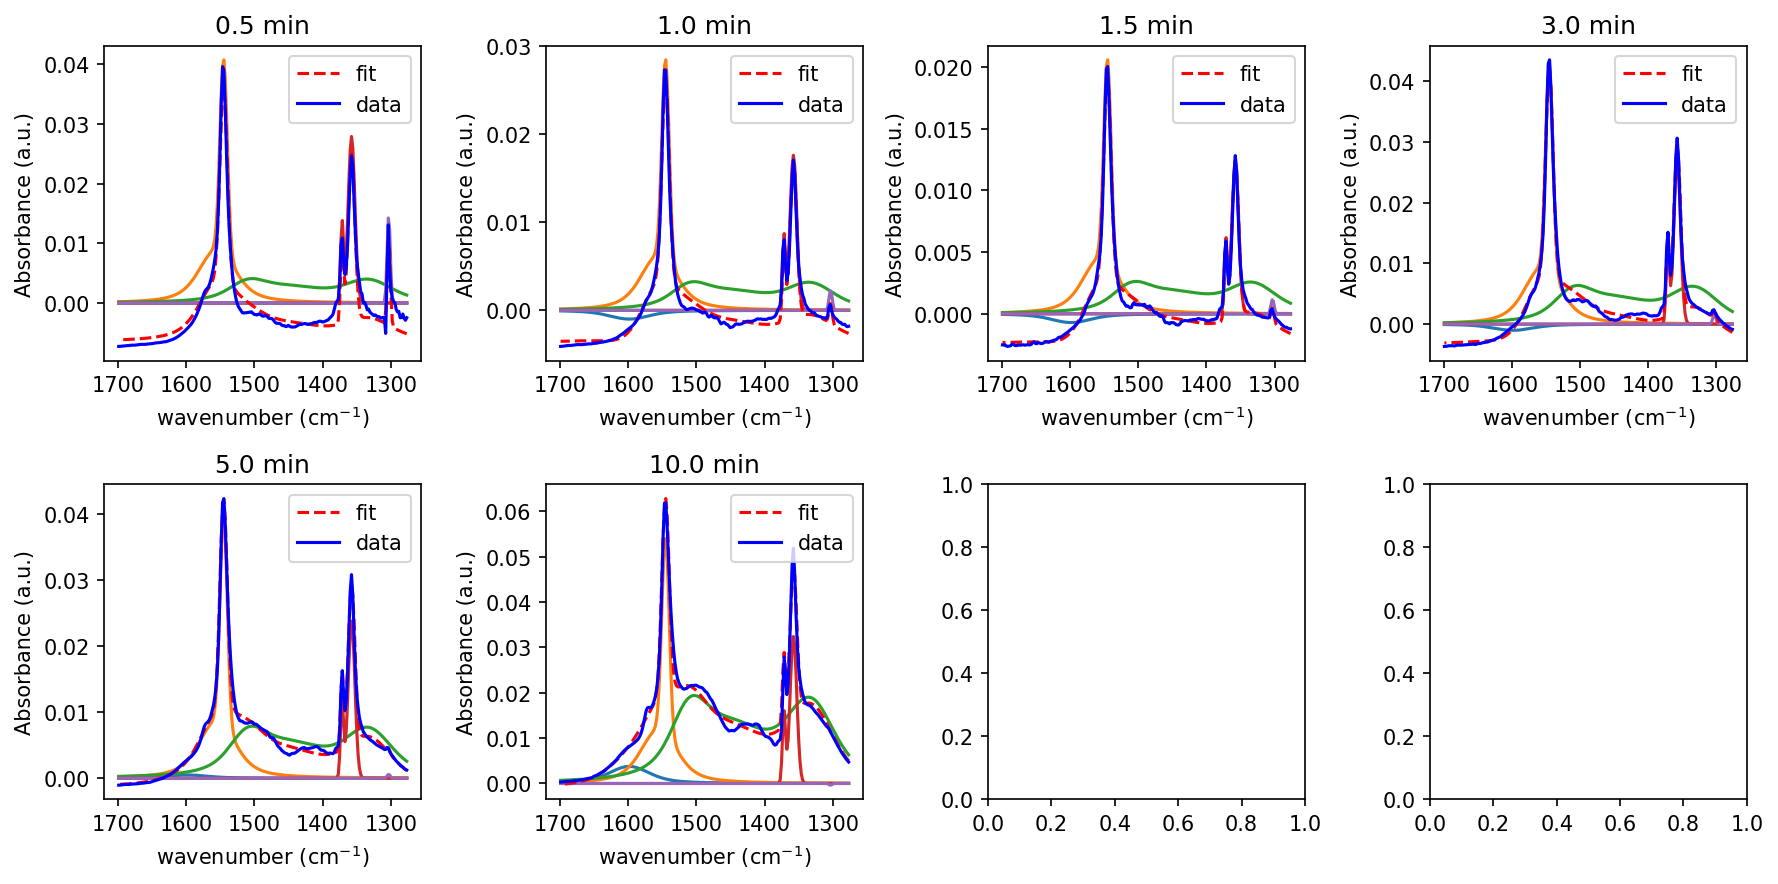

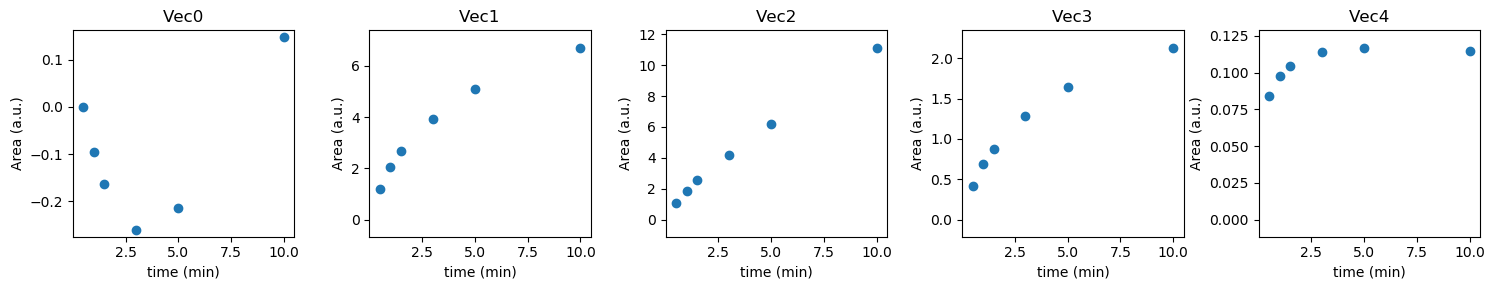

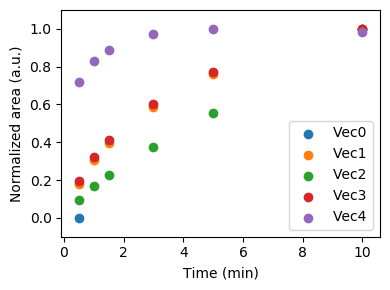

In [40]:
new_params0 = result.params
print('The score of the fit is:', result.chisqr)
Plot_data(new_params0,x_CC,y_CC[:ndata],Vec_fit_CC0,time_CH[:ndata],True)

### Fitting the Middle Stage (20,120) min

We use postfix _CC1 for fitting of this period.

Below is an intial guess of the peaks.

In [61]:
Vec_CC_IG1 = {'Mus':np.array([1601.5,1544.5,1548.3,1488.25,1424.5, 1349.9,1371.1,1357.8,1304]),
             'Sigmas':np.array([10,3.624,17.8,13.4,17.9, 22.9,1.764,4.375,2]),
             'Types':np.array([1,0,1,1,1,1,0,0,0]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':False,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}
             }


In [62]:
t0 = time.time()
nstart = 6
ndata = 5

fit_params_IG1 = Generate_params_IG(x_CC,Vec_CC_IG1,ndata = ndata)

fitter = Minimizer(loss_func_IG, fit_params_IG1, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_CC_IG1))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 218.75275492668152


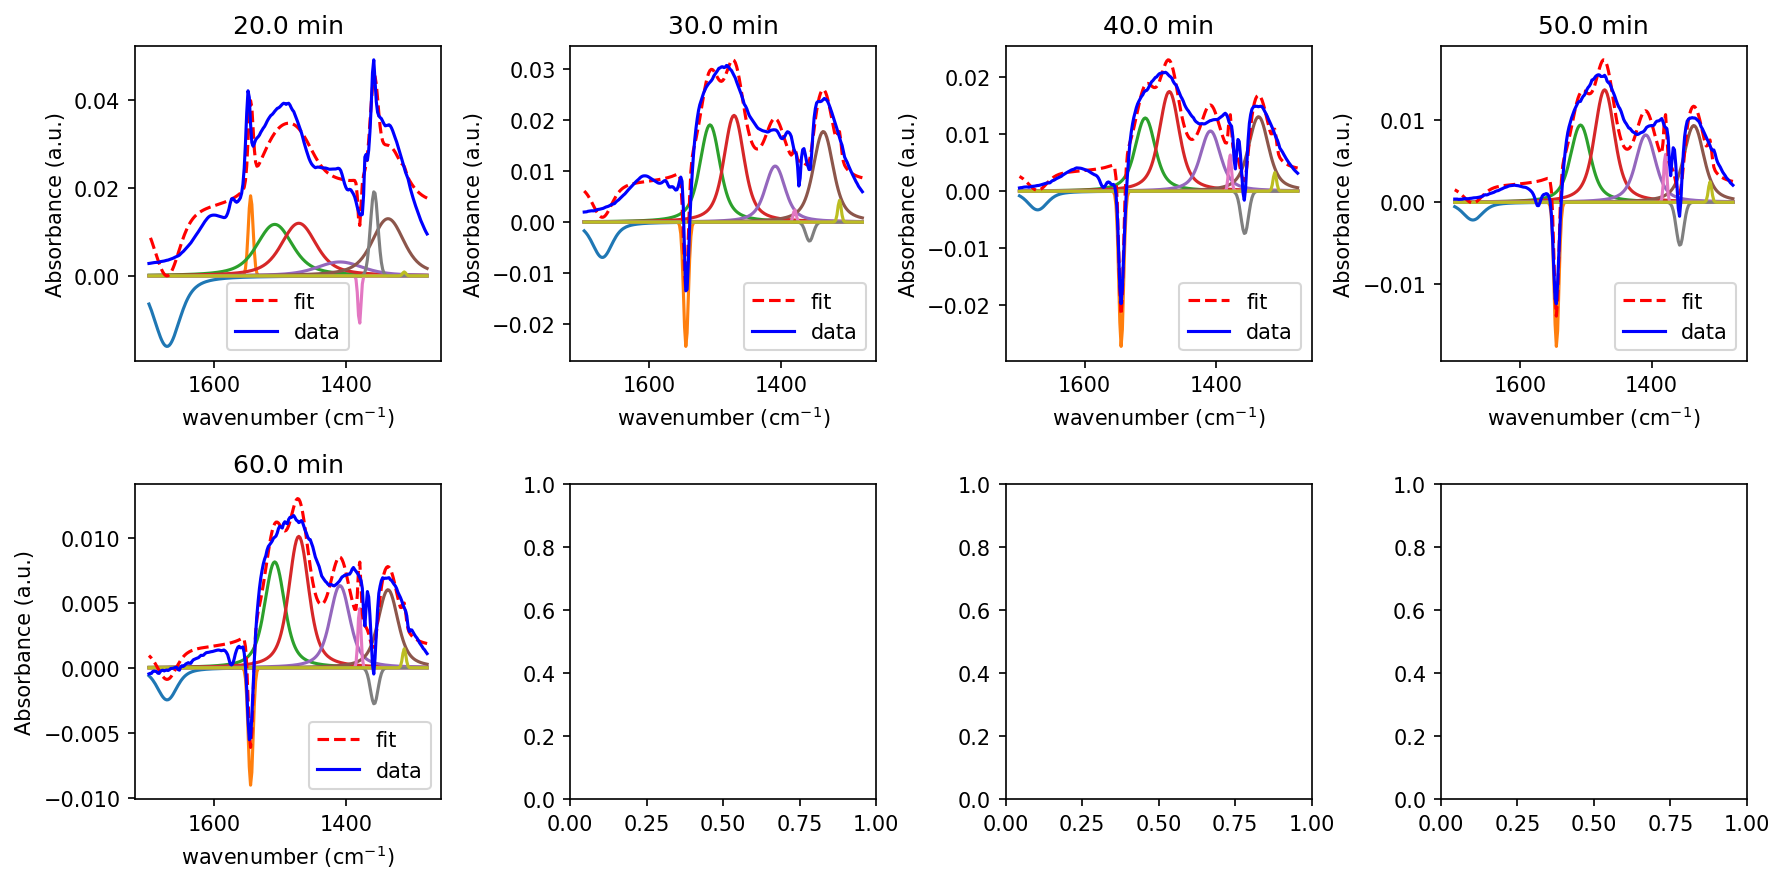

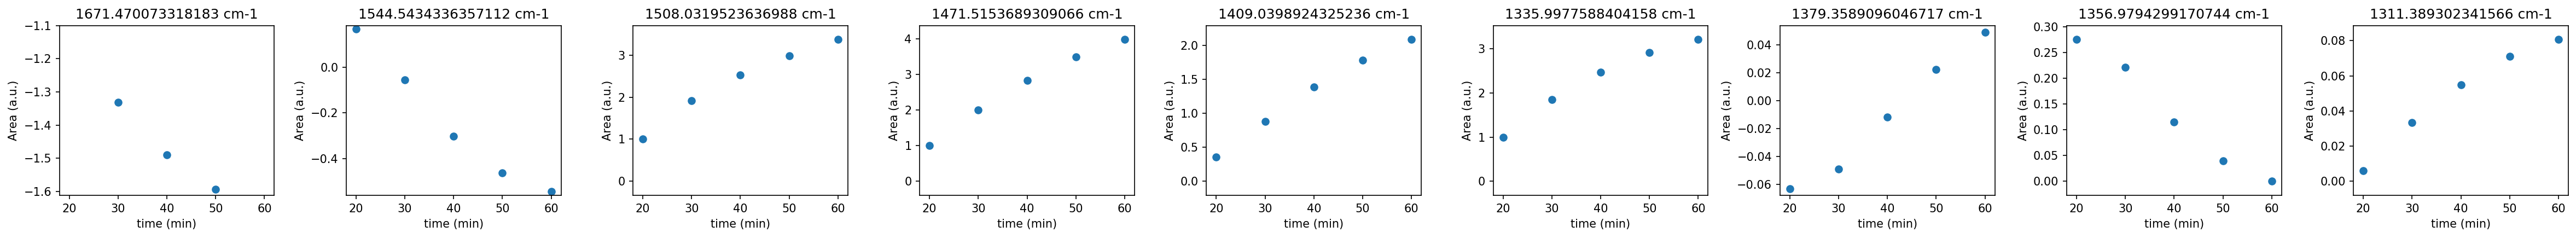

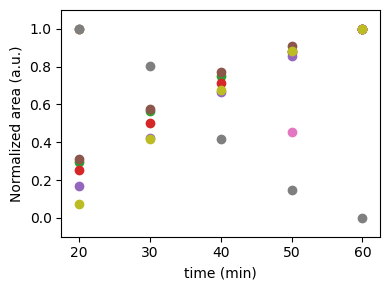

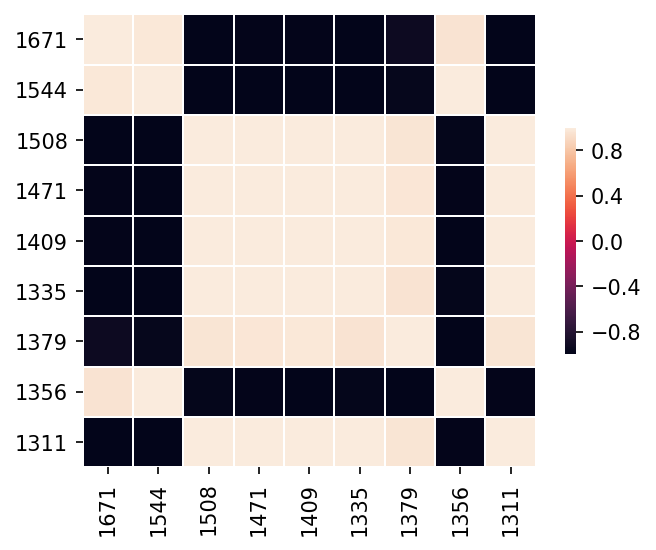

{'Peak Pos': [1671, 1544, 1508, 1471, 1409, 1335, 1379, 1356, 1311],
 'Amps': array([[-9.99998189e-01,  1.65868083e-01,  1.00000000e+00,
          1.00000000e+00,  3.53570695e-01,  1.00000000e+00,
         -6.31766935e-02,  2.74767409e-01,  5.89528234e-03],
        [-1.33189151e+00, -5.53762068e-02,  1.91108841e+00,
          2.00000000e+00,  8.78662854e-01,  1.84846386e+00,
         -4.92743472e-02,  2.21458195e-01,  3.35478935e-02],
        [-1.48910001e+00, -3.02838302e-01,  2.52552088e+00,
          2.83667603e+00,  1.38409266e+00,  2.47363225e+00,
         -1.20422272e-02,  1.15030129e-01,  5.47580810e-02],
        [-1.59313788e+00, -4.62990737e-01,  2.97742983e+00,
          3.49482137e+00,  1.77832140e+00,  2.92255067e+00,
          2.23139322e-02,  3.98475480e-02,  7.10741959e-02],
        [-1.71161981e+00, -5.45149888e-01,  3.36802173e+00,
          3.97958364e+00,  2.08163110e+00,  3.21046934e+00,
          4.90518805e-02,  1.14010427e-04,  8.06222900e-02]])}

In [63]:
params_IG1 = result.params
Plot_data_IG(params_IG1,x_CC,y_CC[nstart:nstart+ndata],Vec_CC_IG1,time_CH[nstart:nstart+ndata],True)

In [64]:
Vec_fit_CC1 = Generate_Vec_IG(params_IG,Vec_IG_CC0,ndata)
print(Vec_fit_CC1)
Vec_fit_CC1['Vec0']['Mus'][0]=1605.
Vec_fit_CC1['Vec1']['Sigmas'][1]=7.8

{'Vec0': {'Mus': array([1590.]), 'Sigmas': array([12.81243924]), 'Amps': array([0.05331234]), 'Types': [1], 'Lims': None}, 'Vec1': {'Mus': array([1545.43743782, 1544.22569279]), 'Sigmas': array([ 3.624, 17.8  ]), 'Amps': array([0.22633826, 0.76611355]), 'Types': [0, 1], 'Lims': None}, 'Vec2': {'Mus': array([1493.12232163, 1419.46488857, 1334.32632576]), 'Sigmas': array([10.00000922, 23.24997103, 29.76545358]), 'Amps': array([0.18071199, 0.17942651, 0.37239383]), 'Types': [1, 1, 1], 'Lims': None}, 'Vec3': {'Mus': array([1371.58346227, 1357.78272854]), 'Sigmas': array([2.29297972, 5.11927331]), 'Amps': array([0.07052753, 0.28194546]), 'Types': [0, 0], 'Lims': None}, 'Vec4': {'Mus': array([1302.94514997]), 'Sigmas': array([2.6]), 'Amps': array([0.03134124]), 'Types': [0], 'Lims': None}, 'Alphas': array([[0.06521266, 0.03739559, 0.0212456 , 0.05897577, 0.08373211],
       [1.34980635, 0.75255054, 0.54830939, 1.16753572, 1.14405702],
       [1.18088461, 0.42039579, 0.33777635, 0.80786905, 0

In [65]:
t0 = time.time()
#Vec_fit_CC1['Alphas'] = None

#Vec_fit_CC1['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1355,1355],[1370,1370],[1.2,1.2],[3.5,4],[-10,-10]])}
fit_params_CC1 = Generate_params(x_CC,Vec_fit_CC1,ndata =ndata)
fitter = Minimizer(loss_func, fit_params_CC1, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_fit_CC1))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 12.812439240938023 0.1 27.812439240938023
0 1605.0 1575.0 1635.0
1 3.624 0.1 8.624
1 1545.4374378214575 1540.4374378214575 1550.4374378214575
1 7.8 0.1 22.8
1 1544.2256927903602 1514.2256927903602 1574.2256927903602
2 10.00000922262351 0.1 25.00000922262351
2 1493.1223216270507 1463.1223216270507 1523.1223216270507
2 23.249971034299413 8.249971034299413 38.24997103429941
2 1419.464888574726 1389.464888574726 1449.464888574726
2 29.765453583261802 14.765453583261802 44.7654535832618
2 1334.3263257562814 1304.3263257562814 1364.3263257562814
3 2.29297972025833 0.1 7.29297972025833
3 1371.5834622729178 1366.5834622729178 1376.5834622729178
3 5.119273305979536 0.11927330597953567 10.119273305979537
3 1357.7827285360154 1352.7827285360154 1362.7827285360154
4 2.5999999999966406 0.1 7.5999999999966406
4 1302.9451499671427 1297.9451499671427 1307.9451499671427
The time cost is: 43.09469389915466


The score of the fit is: 0.0021015391378408628
Plotting.....


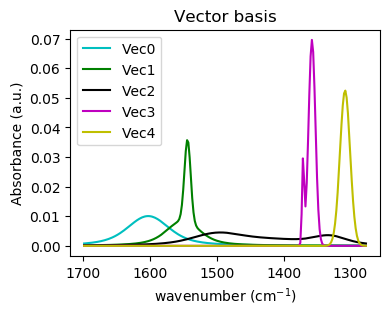

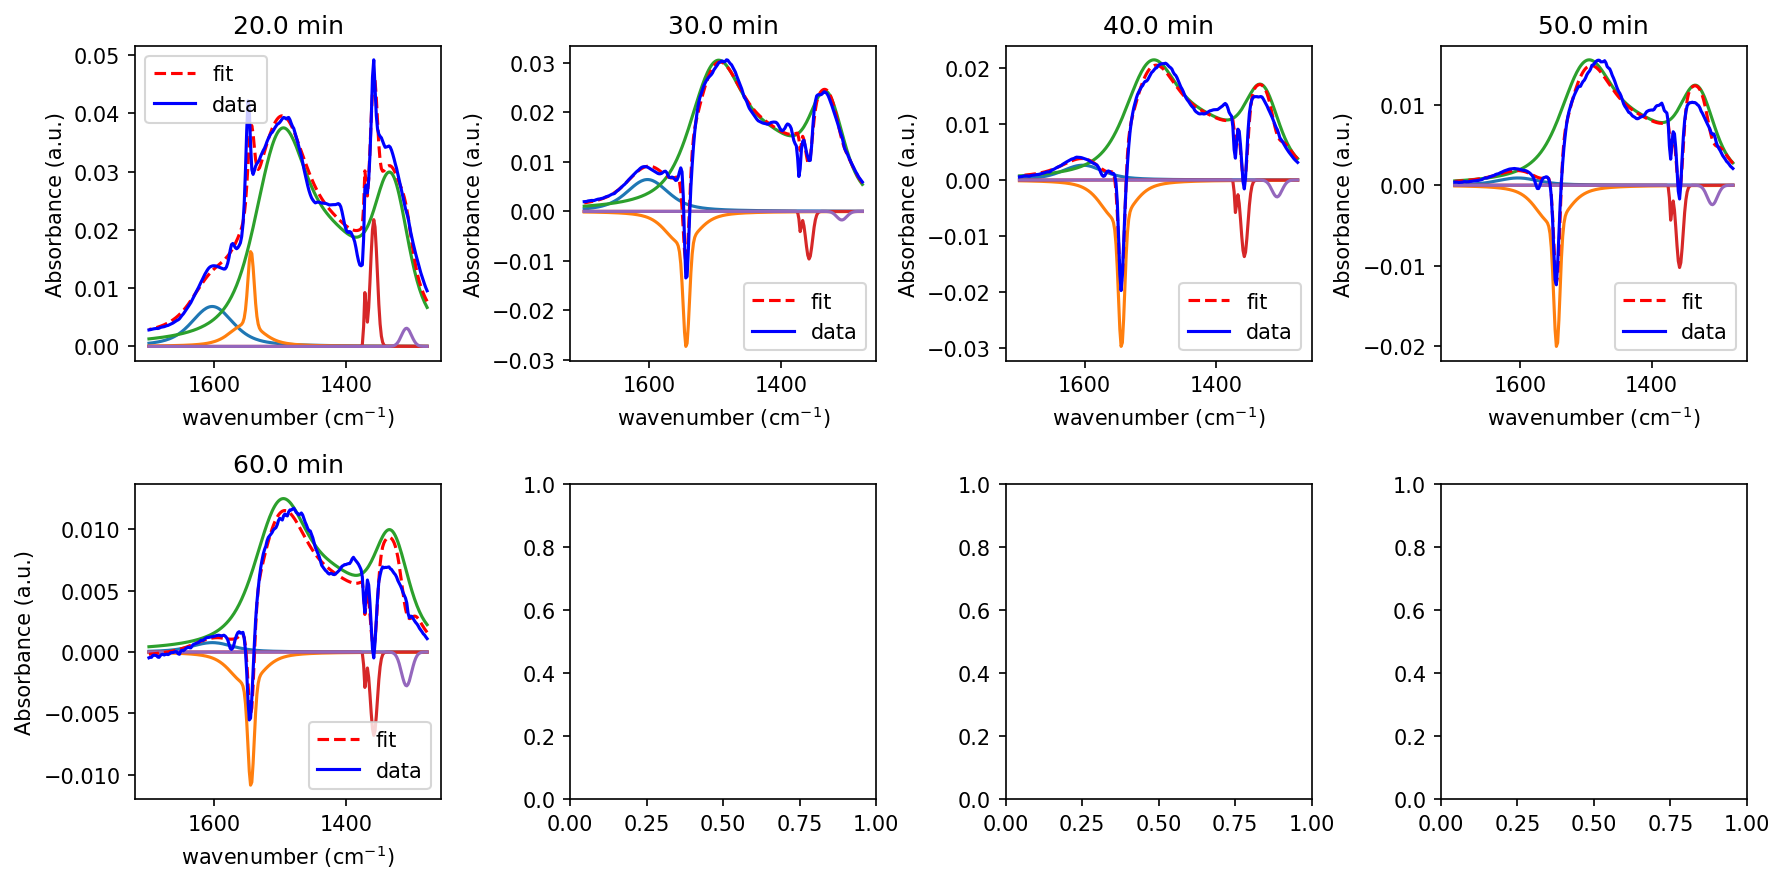

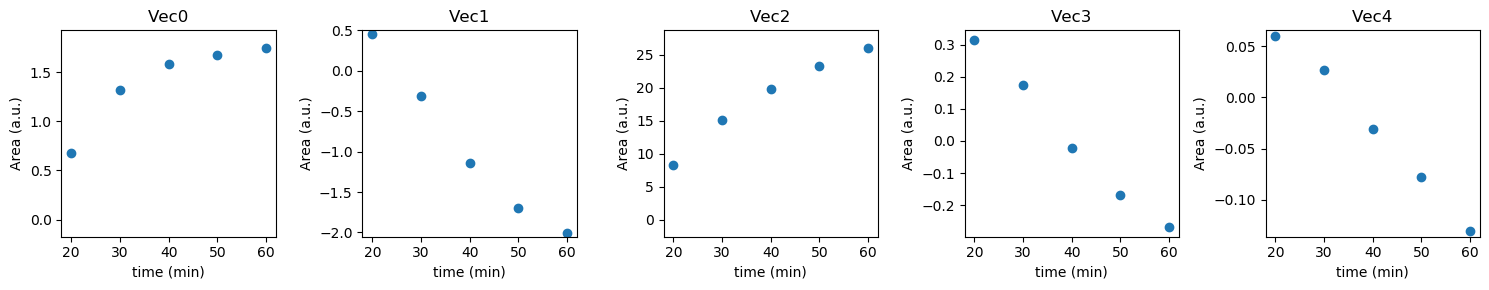

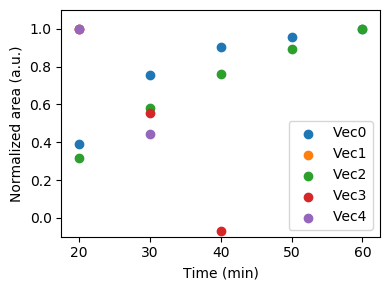

In [66]:
new_params1 = result.params
print('The score of the fit is:', result.chisqr)
Plot_data(new_params1,x_CC,y_CC[nstart:nstart+ndata],Vec_fit_CC1,time_CH[nstart:nstart+ndata],True)

### Fitting the Final Stage (180,720) min

We use postfix _CC2 for fitting of this period.

Below is an intial guess of the peaks.

In [102]:
Vec_IG_CC2 = {'Mus':np.array([1600, 1537.8, 1541.7, 1473.6, 1386, 1352, 1369.1, 1357.9, 1303.9]),
             'Sigmas':np.array([15.9, 4.4,18.7, 20, 18, 8.7, 2.4, 4, 2.37]),
             'Types':np.array([0,1,0,0,0,0,1,1,1]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':False,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}
             }


In [103]:
t0 = time.time()
nstart = 11
ndata = 7
fit_params_IG2 = Generate_params_IG(x_CC,Vec_IG_CC2,ndata = ndata)
fitter = Minimizer(loss_func_IG, fit_params_IG2, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_IG_CC2))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 232.70883584022522


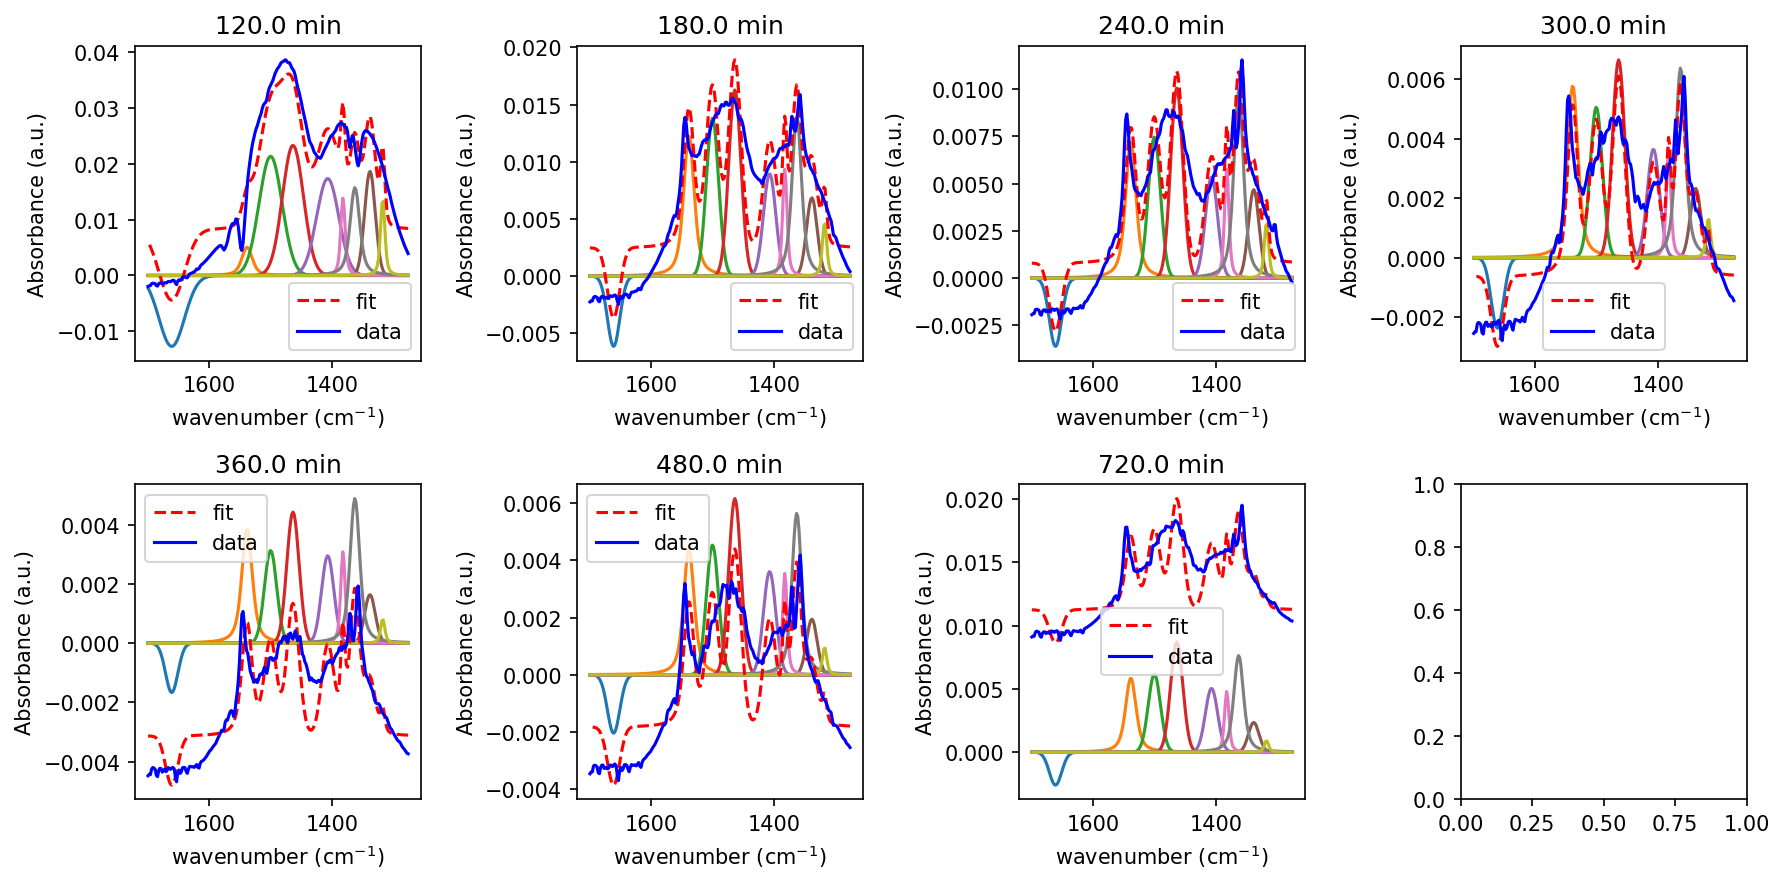

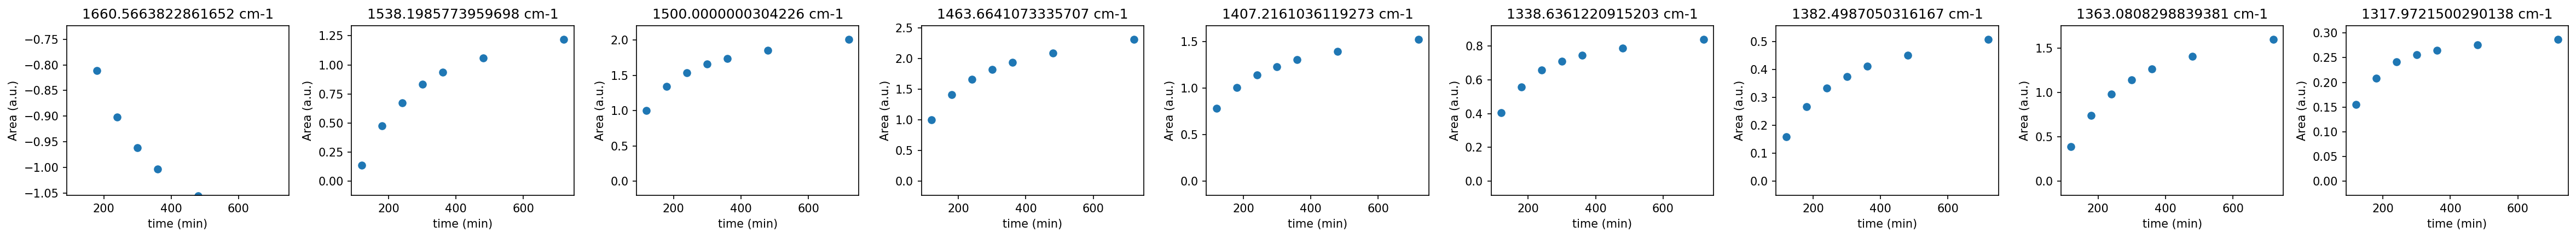

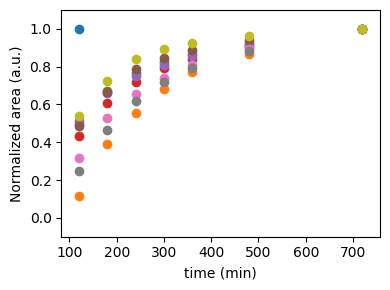

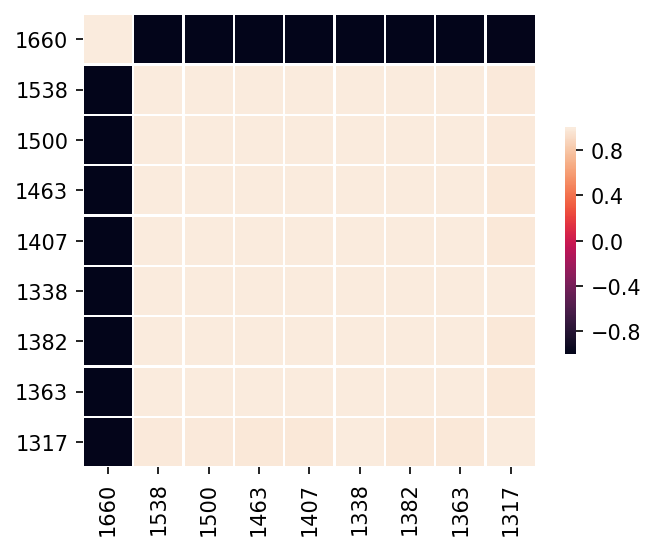

{'Peak Pos': [1660, 1538, 1500, 1463, 1407, 1338, 1382, 1363, 1317],
 'Amps': array([[-0.65759153,  0.13845945,  1.        ,  1.        ,  0.78300322,
          0.4066224 ,  0.15942675,  0.39206944,  0.15474377],
        [-0.81165346,  0.47529305,  1.34579872,  1.40785949,  1.00740369,
          0.55601063,  0.26704956,  0.73852441,  0.20798361],
        [-0.90207448,  0.67257557,  1.53277758,  1.65954047,  1.14138052,
          0.65803054,  0.33330072,  0.98476407,  0.24126041],
        [-0.96142069,  0.83098358,  1.65949036,  1.82610804,  1.23269368,
          0.70874749,  0.3757578 ,  1.14357287,  0.25620571],
        [-1.00317255,  0.93635888,  1.73784392,  1.93694799,  1.30665137,
          0.74440356,  0.41129872,  1.26522784,  0.26537556],
        [-1.05441013,  1.05681774,  1.85165294,  2.09147134,  1.39721689,
          0.78679166,  0.45216503,  1.40606234,  0.27622524],
        [-1.11967109,  1.21707089,  2.00587229,  2.30958217,  1.52353984,
          0.83795982,  0.50737603

In [104]:
params_IG2 = result.params
Plot_data_IG(params_IG2,x_CC,y_CC[nstart:nstart+ndata],Vec_IG_CC2,time_CH[nstart:nstart+ndata],True)

In [105]:
Vec_fit_CC2 = Generate_Vec_IG(params_IG2,Vec_IG_CC0,ndata)

In [106]:
t0 = time.time()
Vec_fit_CC2['Vec1']['Mus'][1]=1520.

Vec_fit_CC2['Vec2']['Mus'][0]=1463.6
Vec_fit_CC2['Vec2']['Mus'][1]=1407.2
Vec_fit_CC2['Vec2']['Mus'][2]=1338.6

Vec_fit_CC2['Alphas'] = None
Vec_fit_CC2['Vec0']['Lims'] = {'Peaks':np.array([0]),'Specs':np.array([[0],[1610],[10],[20],[-10]])}
Vec_fit_CC2['Vec1']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1700,1580],[1500,1410],[1.2,0.1],[7.5,25],[-1,-1]])}
Vec_fit_CC2['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1355,1355],[1370,1370],[1.2,1.2],[5,5],[-10,-10]])}

fit_params_CC2 = Generate_params(x_CC,Vec_fit_CC2,ndata=ndata)

fitter = Minimizer(loss_func, fit_params_CC2, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_fit_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 20.669999608291064 10 20
0 1660.5663822861652 1630.5663822861652 1610
1 5.719999999999999 1.2 6.5
1 1538.1985773959698 1700.0 1500.0
1 18.7 3.6999999999999993 25.0
1 1520.0 1580.0 1410.0
2 17.12901126105693 2.129011261056931 32.12901126105693
2 1463.6 1433.6 1493.6
2 18.0 3.0 33.0
2 1407.2 1377.2 1437.2
2 8.7 0.1 23.7
2 1338.6 1308.6 1368.6
3 2.4 1.2 5.0
3 1382.4987050316167 1377.4987050316167 1370.0
3 5.1999999999999975 1.2 5.0
3 1363.0808298839381 1358.0808298839381 1368.0808298839381
4 2.37 0.1 7.37
4 1317.9721500290138 1312.9721500290138 1322.9721500290138
The time cost is: 286.1173210144043


The score of the fit is: 6.631730401373765e-07
Plotting.....


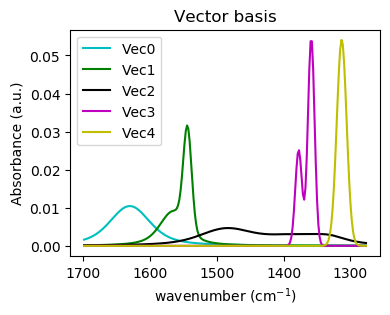

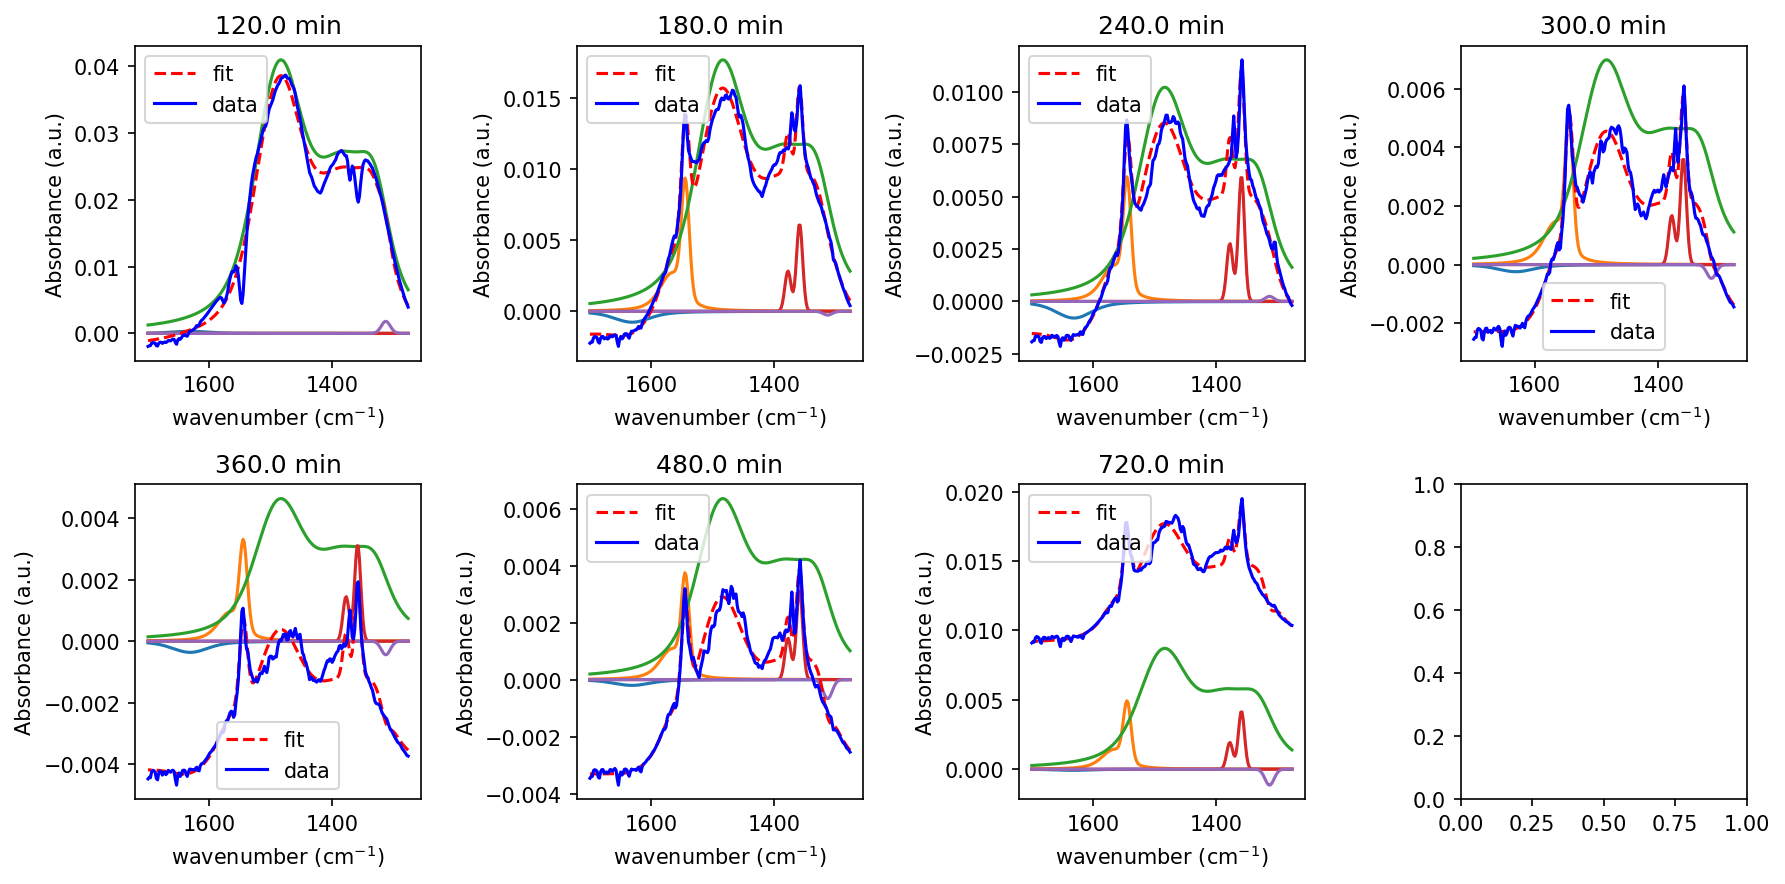

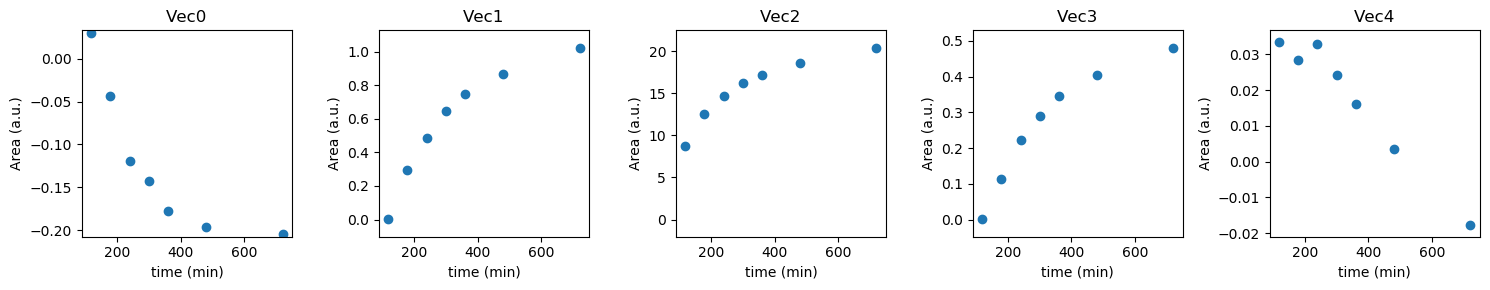

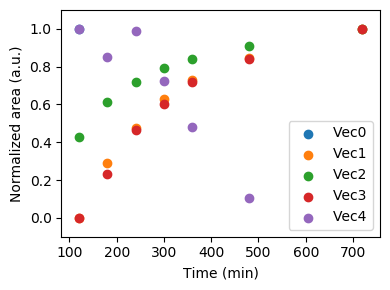

In [107]:
new_params2 = result.params
print('The score of the fit is:', result.redchi)
Plot_data(new_params2,x_CC,y_CC[nstart:nstart+ndata],Vec_fit_CC2,time_CH[nstart:nstart+ndata],True)

In [95]:
report_fit(new_params2)

[[Variables]]
    lin_0:    0.00899255 +/- 8.0514e-04 (8.95%) (init = 0)
    amp_000: -2.06612066 +/- 0.21142055 (10.23%) (init = -0.0159953)
    cen_000:  1658.62214 +/- 2.40447866 (0.14%) (init = 1660.566)
    sig_000:  35.6395247 +/- 2.39828979 (6.73%) (init = 20.67)
    amp_010: -0.03498127 +/- 0.01063197 (30.39%) (init = 0.01738673)
    cen_010:  1544.66922 +/- 0.50777425 (0.03%) (init = 1538.199)
    sig_010:  3.46331282 +/- 0.52060401 (15.03%) (init = 5.72)
    amp_011: -0.04149741 +/- 0.06916150 (166.66%) (init = 0.02865532)
    cen_011:  1414.53014 +/- 27.3117207 (1.93%) (init = 1520)
    sig_011:  24.9664492 +/- 29.1180869 (116.63%) (init = 18.7)
    amp_020:  1.37376784 +/- 0.22926757 (16.69%) (init = 0.03299403)
    cen_020:  1493.48739 +/- 1.24377840 (0.08%) (init = 1463.6)
    sig_020:  14.7579350 +/- 1.19318918 (8.09%) (init = 17.12901)
    amp_021:  3.37342528 +/- 0.50022979 (14.83%) (init = 0.02176485)
    cen_021:  1424.42012 +/- 3.87924132 (0.27%) (init = 1407.2)
   

array([[ 6.58390517e-05, -9.50127549e-02, -1.62675130e-01,
        -2.60527901e-01, -2.13394658e-01,  1.47598929e-01,
         8.29637138e-01,  1.47013763e+00,  1.73324918e+00,
         1.82313290e+00,  1.89941955e+00,  1.92981188e+00,
         1.85600575e+00,  1.77987610e+00,  1.75664840e+00,
         1.72178624e+00,  1.70239080e+00,  1.69460411e+00],
       [ 1.21022878e+00,  2.05531770e+00,  2.66567994e+00,
         3.93378019e+00,  5.10638265e+00,  6.71061903e+00,
         7.16653195e+00,  6.40156341e+00,  5.56990266e+00,
         5.00731996e+00,  4.70332553e+00,  4.70346438e+00,
         5.00005800e+00,  5.18840665e+00,  5.34916657e+00,
         5.45377584e+00,  5.57248802e+00,  5.72854893e+00],
       [ 1.04628785e+00,  1.87882319e+00,  2.54962233e+00,
         4.17763605e+00,  6.18981351e+00,  1.11460310e+01,
         1.94601366e+01,  2.62334541e+01,  3.09838281e+01,
         3.44443563e+01,  3.72152907e+01,  4.59740081e+01,
         4.97639114e+01,  5.19545542e+01,  5.34493253e

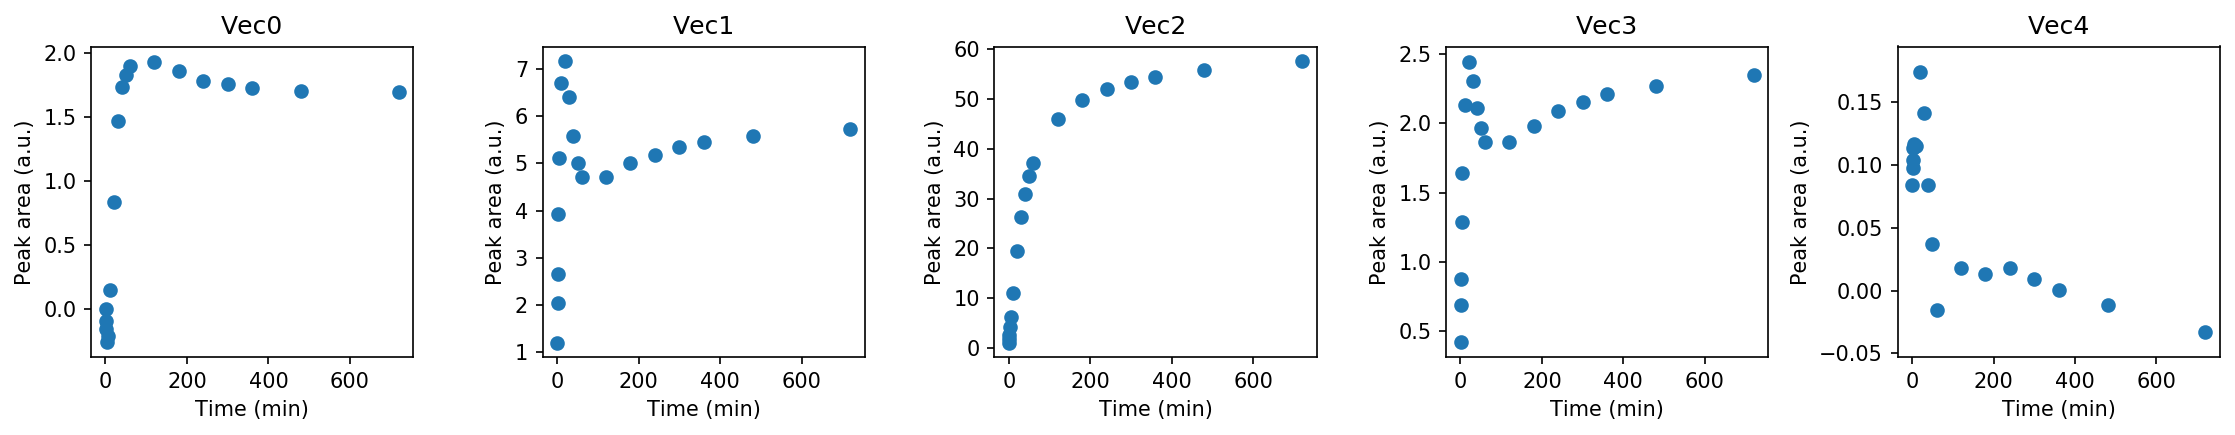

In [150]:
Param_com = {'Params': (new_params0,new_params1,new_params2) ,
            'Lens':np.array([6,5,7])}
Plot_com_data(Param_com,Vec_IG_CC0,Time[:18],True)

## Fitting the 1000 - 1300 cm$^{-1}$ region

This region contains charistic peaks from C-O speices. 

In [120]:
Vec_IG_CO = {'Mus':np.array([1215, 1055, 1112.2]),
          'Sigmas':np.array([5.3,13.6,15.3]),
          'Types':np.array([0,1,1]),
          'Fixed':None,
          'Lims':None}


In [141]:
t0 = time.time()
fit_params_IG_CO = Generate_params_IG(x_CO,Vec_IG_CO,ndata =18)

fitter = Minimizer(loss_func_IG, fit_params_IG_CO, fcn_args=(x_CO, y_CO, Vec_IG_CO))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 6.932566165924072


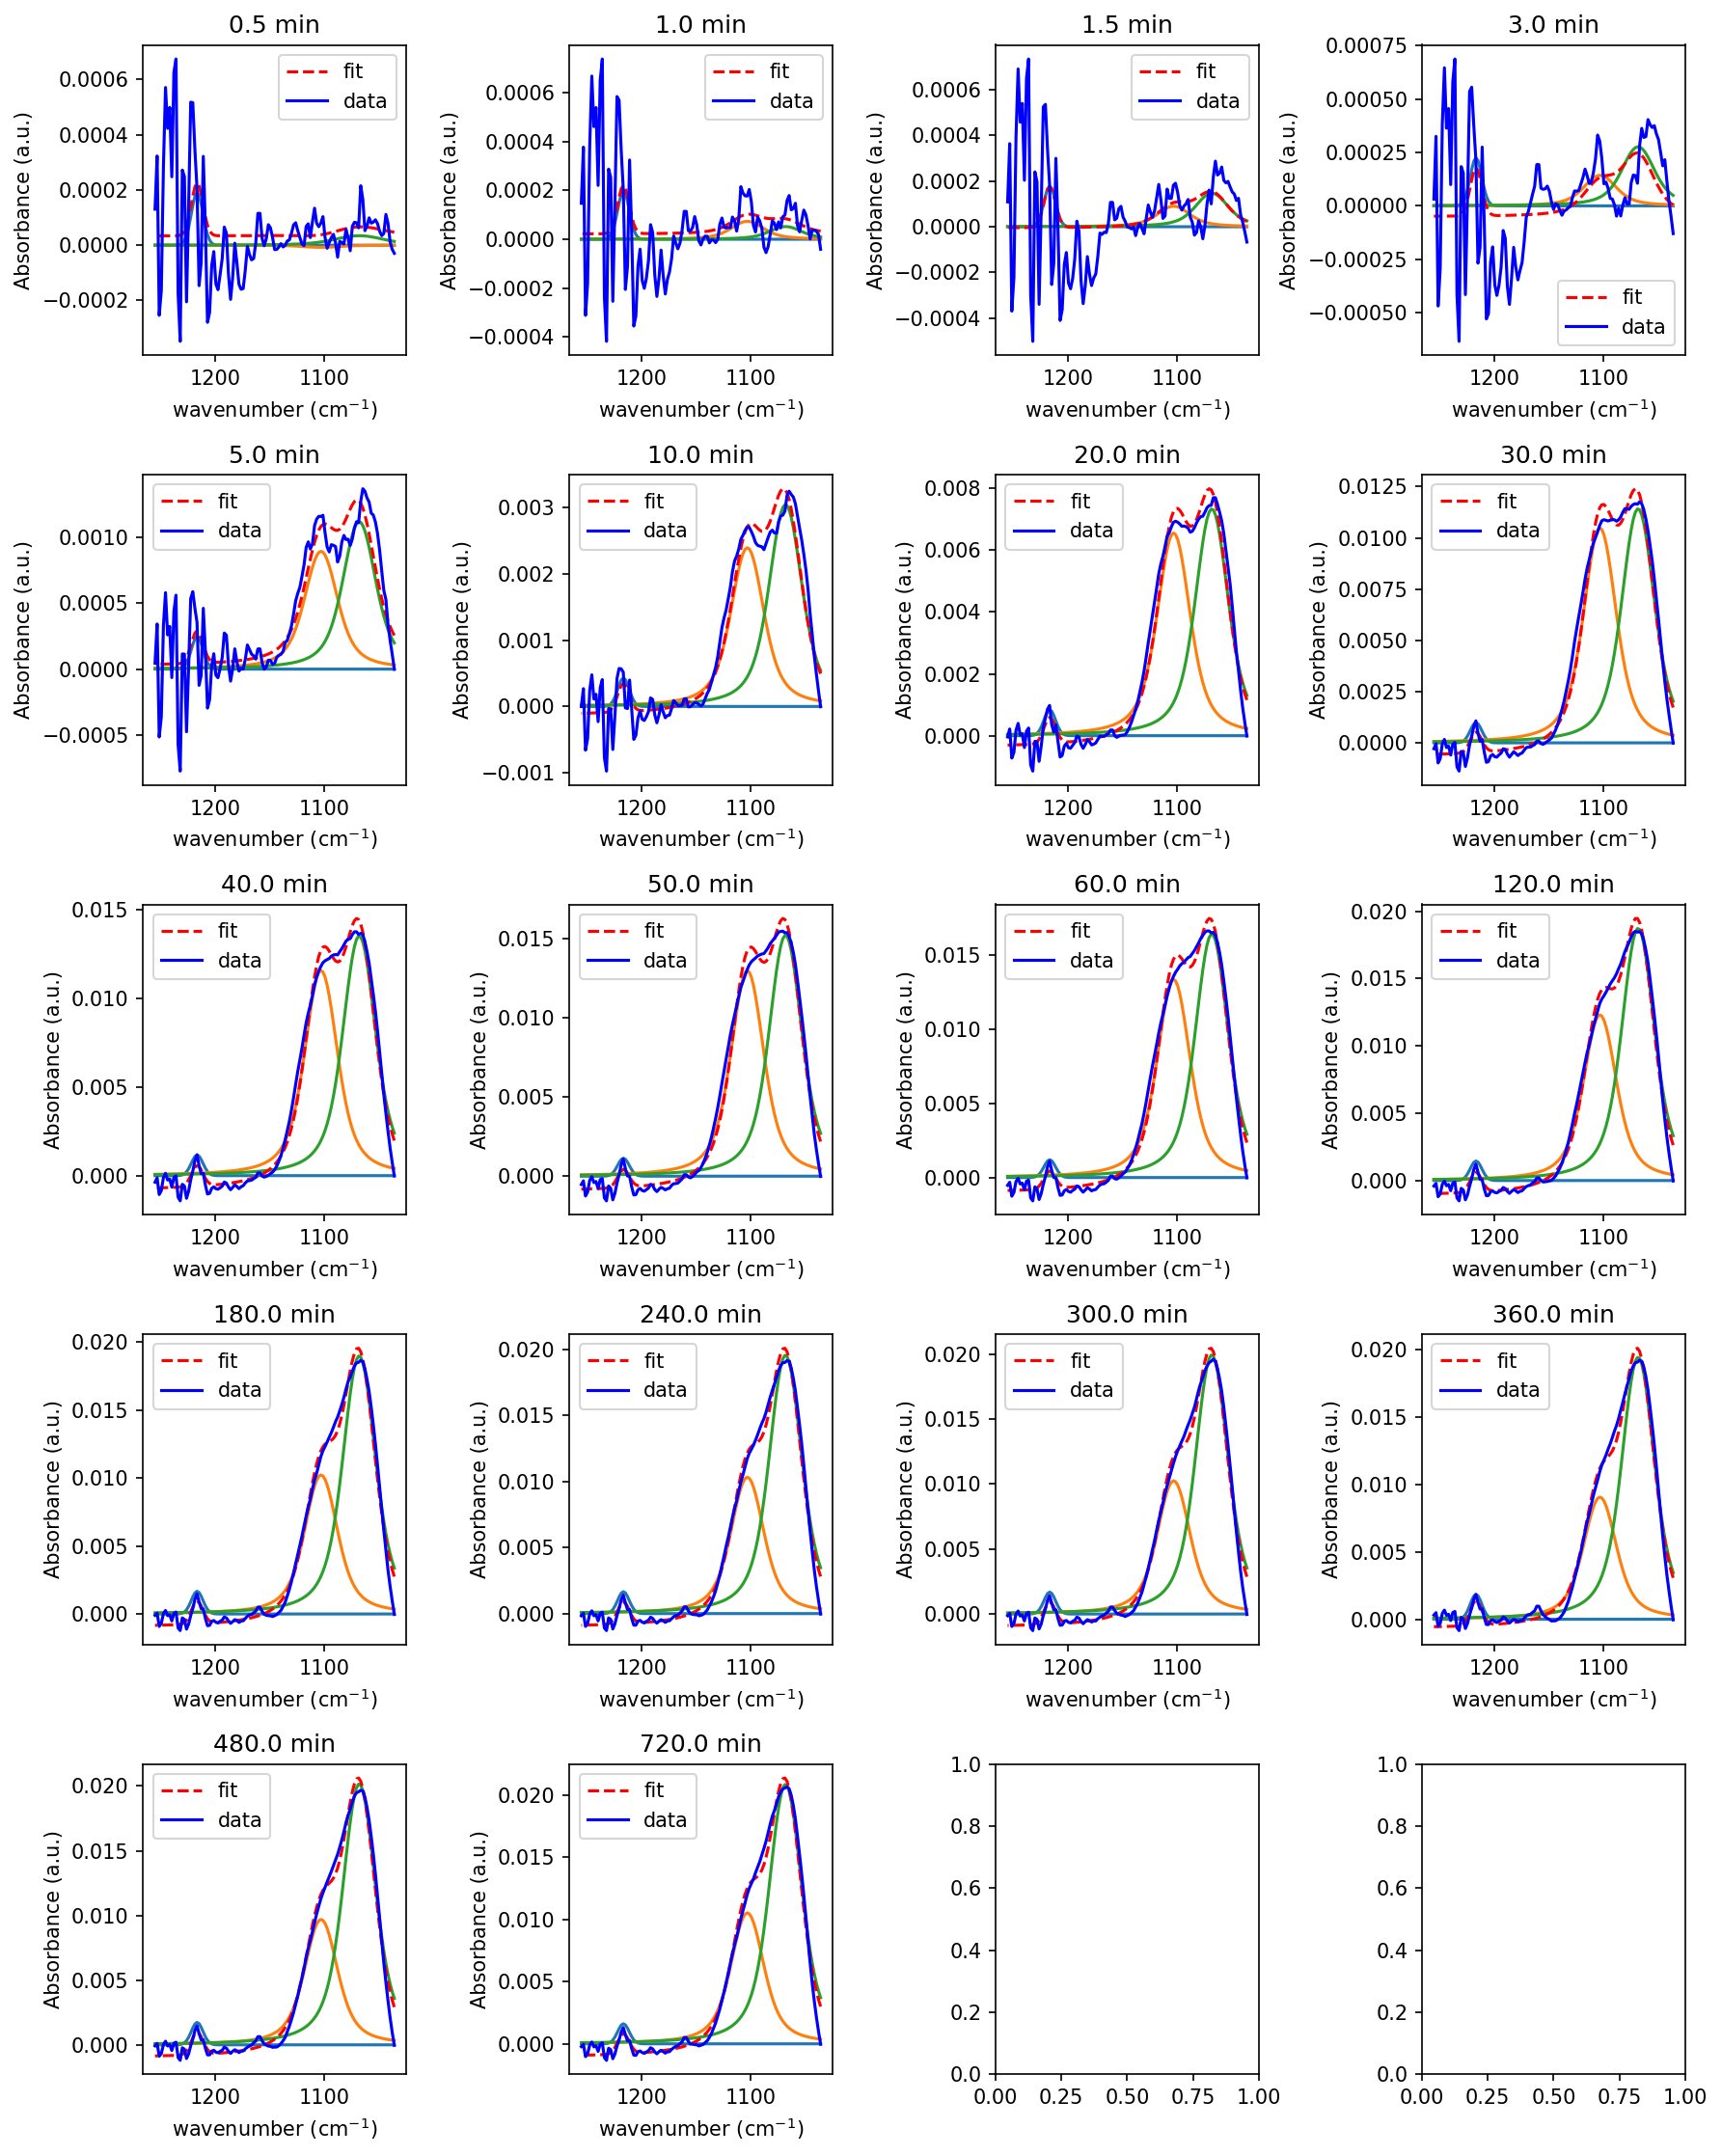

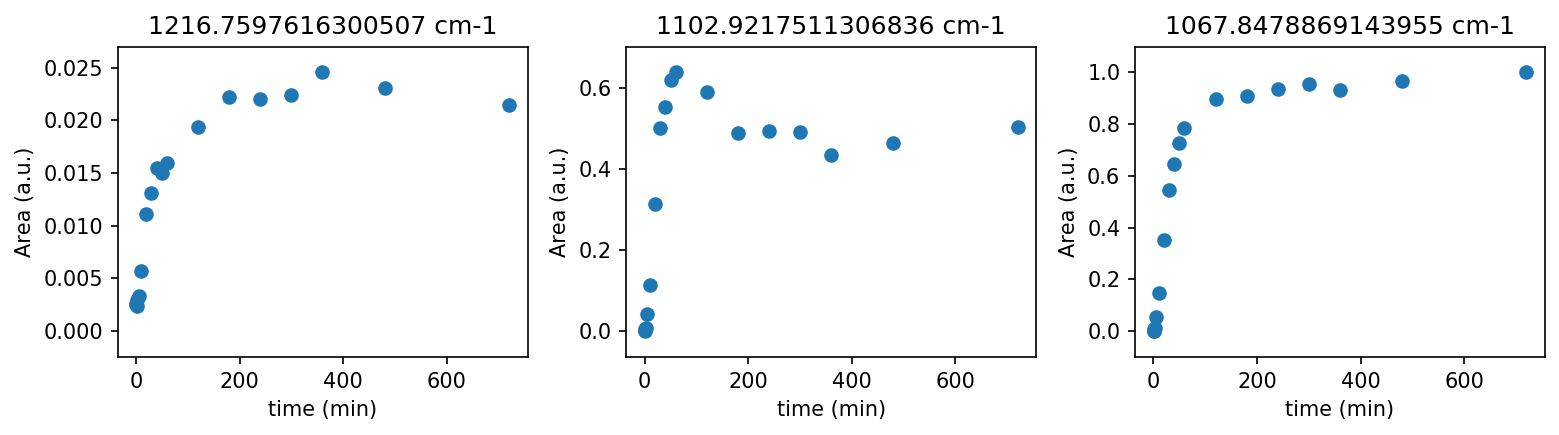

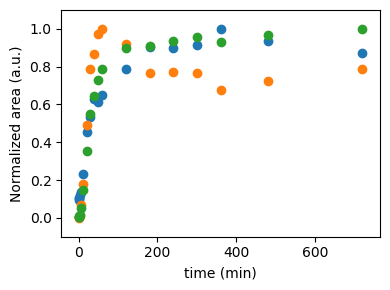

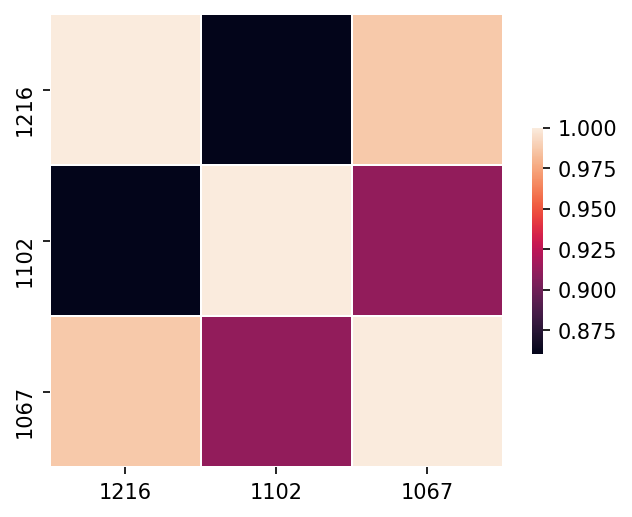

{'Peak Pos': [1216, 1102, 1067],
 'Amps': array([[ 2.53734165e-03, -4.11440384e-04,  2.52405506e-03],
        [ 2.62488010e-03,  3.50724912e-03,  2.48324404e-03],
        [ 2.37022529e-03,  4.29984216e-03,  7.03639097e-03],
        [ 2.98729181e-03,  6.83966296e-03,  1.32411806e-02],
        [ 3.29885837e-03,  4.29296729e-02,  5.37190928e-02],
        [ 5.70334946e-03,  1.14790711e-01,  1.45977565e-01],
        [ 1.11616427e-02,  3.14285882e-01,  3.51609462e-01],
        [ 1.31309838e-02,  5.02221958e-01,  5.47071262e-01],
        [ 1.54576769e-02,  5.53867507e-01,  6.47405686e-01],
        [ 1.50388864e-02,  6.21147232e-01,  7.27550550e-01],
        [ 1.59066802e-02,  6.39143441e-01,  7.85666672e-01],
        [ 1.93204041e-02,  5.89666519e-01,  8.97666202e-01],
        [ 2.22273798e-02,  4.90106756e-01,  9.10181748e-01],
        [ 2.20406178e-02,  4.94335359e-01,  9.36878559e-01],
        [ 2.23974839e-02,  4.90990774e-01,  9.54926193e-01],
        [ 2.45449208e-02,  4.33769172e-01,  

In [142]:
params_IG_CO = result.params
Plot_data_IG(params_IG_CO,x_CO,y_CO,Vec_IG_CO,time_CH[:18],False)

In [143]:
Vec_IG_struc_CO = {'Peaks':[[0,2],[1]],'Types':[[0,1],[1]]}
Vec_fit_CO = Generate_Vec_IG(params_IG_CO,Vec_IG_struc_CO,18)
#Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
 #                          'Specs':np.array([[0.1,0.1,0.1,0.1],
 #                                           [4000,4000,4000,4000],
 #                                           [0.1,.1,0.1,0.1],
  #                                          [6.5,6.5,6.5,6.5]])}


In [144]:
t0 = time.time()
fit_params_CO = Generate_params(x_CO,Vec_fit_CO,ndata = 18)

fitter = Minimizer(loss_func, fit_params_CO, fcn_args=(x_CO, y_CO, Vec_fit_CO))
result = fitter.minimize(method='leastsq')
t1 = time.time()

print('The time cost is:',t1-t0)

0 5.3 0.2999999999999998 10.3
0 1216.7597616300507 1211.7597616300507 1221.7597616300507
0 15.3 0.3000000000000007 30.3
0 1067.8478869143955 1037.8478869143955 1097.8478869143955
1 11.215524953192991 0.1 26.21552495319299
1 1102.9217511306836 1072.9217511306836 1132.9217511306836
The time cost is: 11.703726053237915


In [145]:
new_params_CO = result.params
report_fit(new_params_CO)

[[Variables]]
    lin_0:     5.2372e-05 +/- 6.6544e-05 (127.06%) (init = 0)
    amp_000:   5.0214e-05 +/- 2.0070e-04 (399.68%) (init = 6.895152e-05)
    cen_000:   1216.81586 +/- 0.22602580 (0.02%) (init = 1216.76)
    sig_000:   3.83431896 +/- 0.23532361 (6.14%) (init = 5.3)
    amp_001:   0.00195456 +/- 0.00778913 (398.51%) (init = 0.002778342)
    cen_001:   1066.20804 +/- 0.14141132 (0.01%) (init = 1067.848)
    sig_001:   9.40410125 +/- 0.08368323 (0.89%) (init = 15.3)
    amp_010:  -0.00188614 +/- 0.00946119 (501.62%) (init = -0.0001433312)
    cen_010:   1100.07587 +/- 0.28025755 (0.03%) (init = 1102.922)
    sig_010:   12.1628510 +/- 0.15849132 (1.30%) (init = 11.21552)
    lin_1:     4.2039e-05 +/- 6.6530e-05 (158.26%) (init = 0)
    amp_100:   4.8299e-05 +/- 2.0070e-04 (415.54%) (init = 6.958809e-05)
    cen_100:   1216.81586 +/- 0.22602580 (0.02%) == 'cen_000'
    sig_100:   3.83431896 +/- 0.23532361 (6.14%) == 'sig_000'
    amp_101:   0.00188001 +/- 0.00781155 (415.51%) == 

Plotting.....


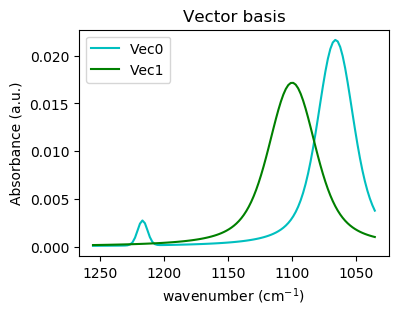

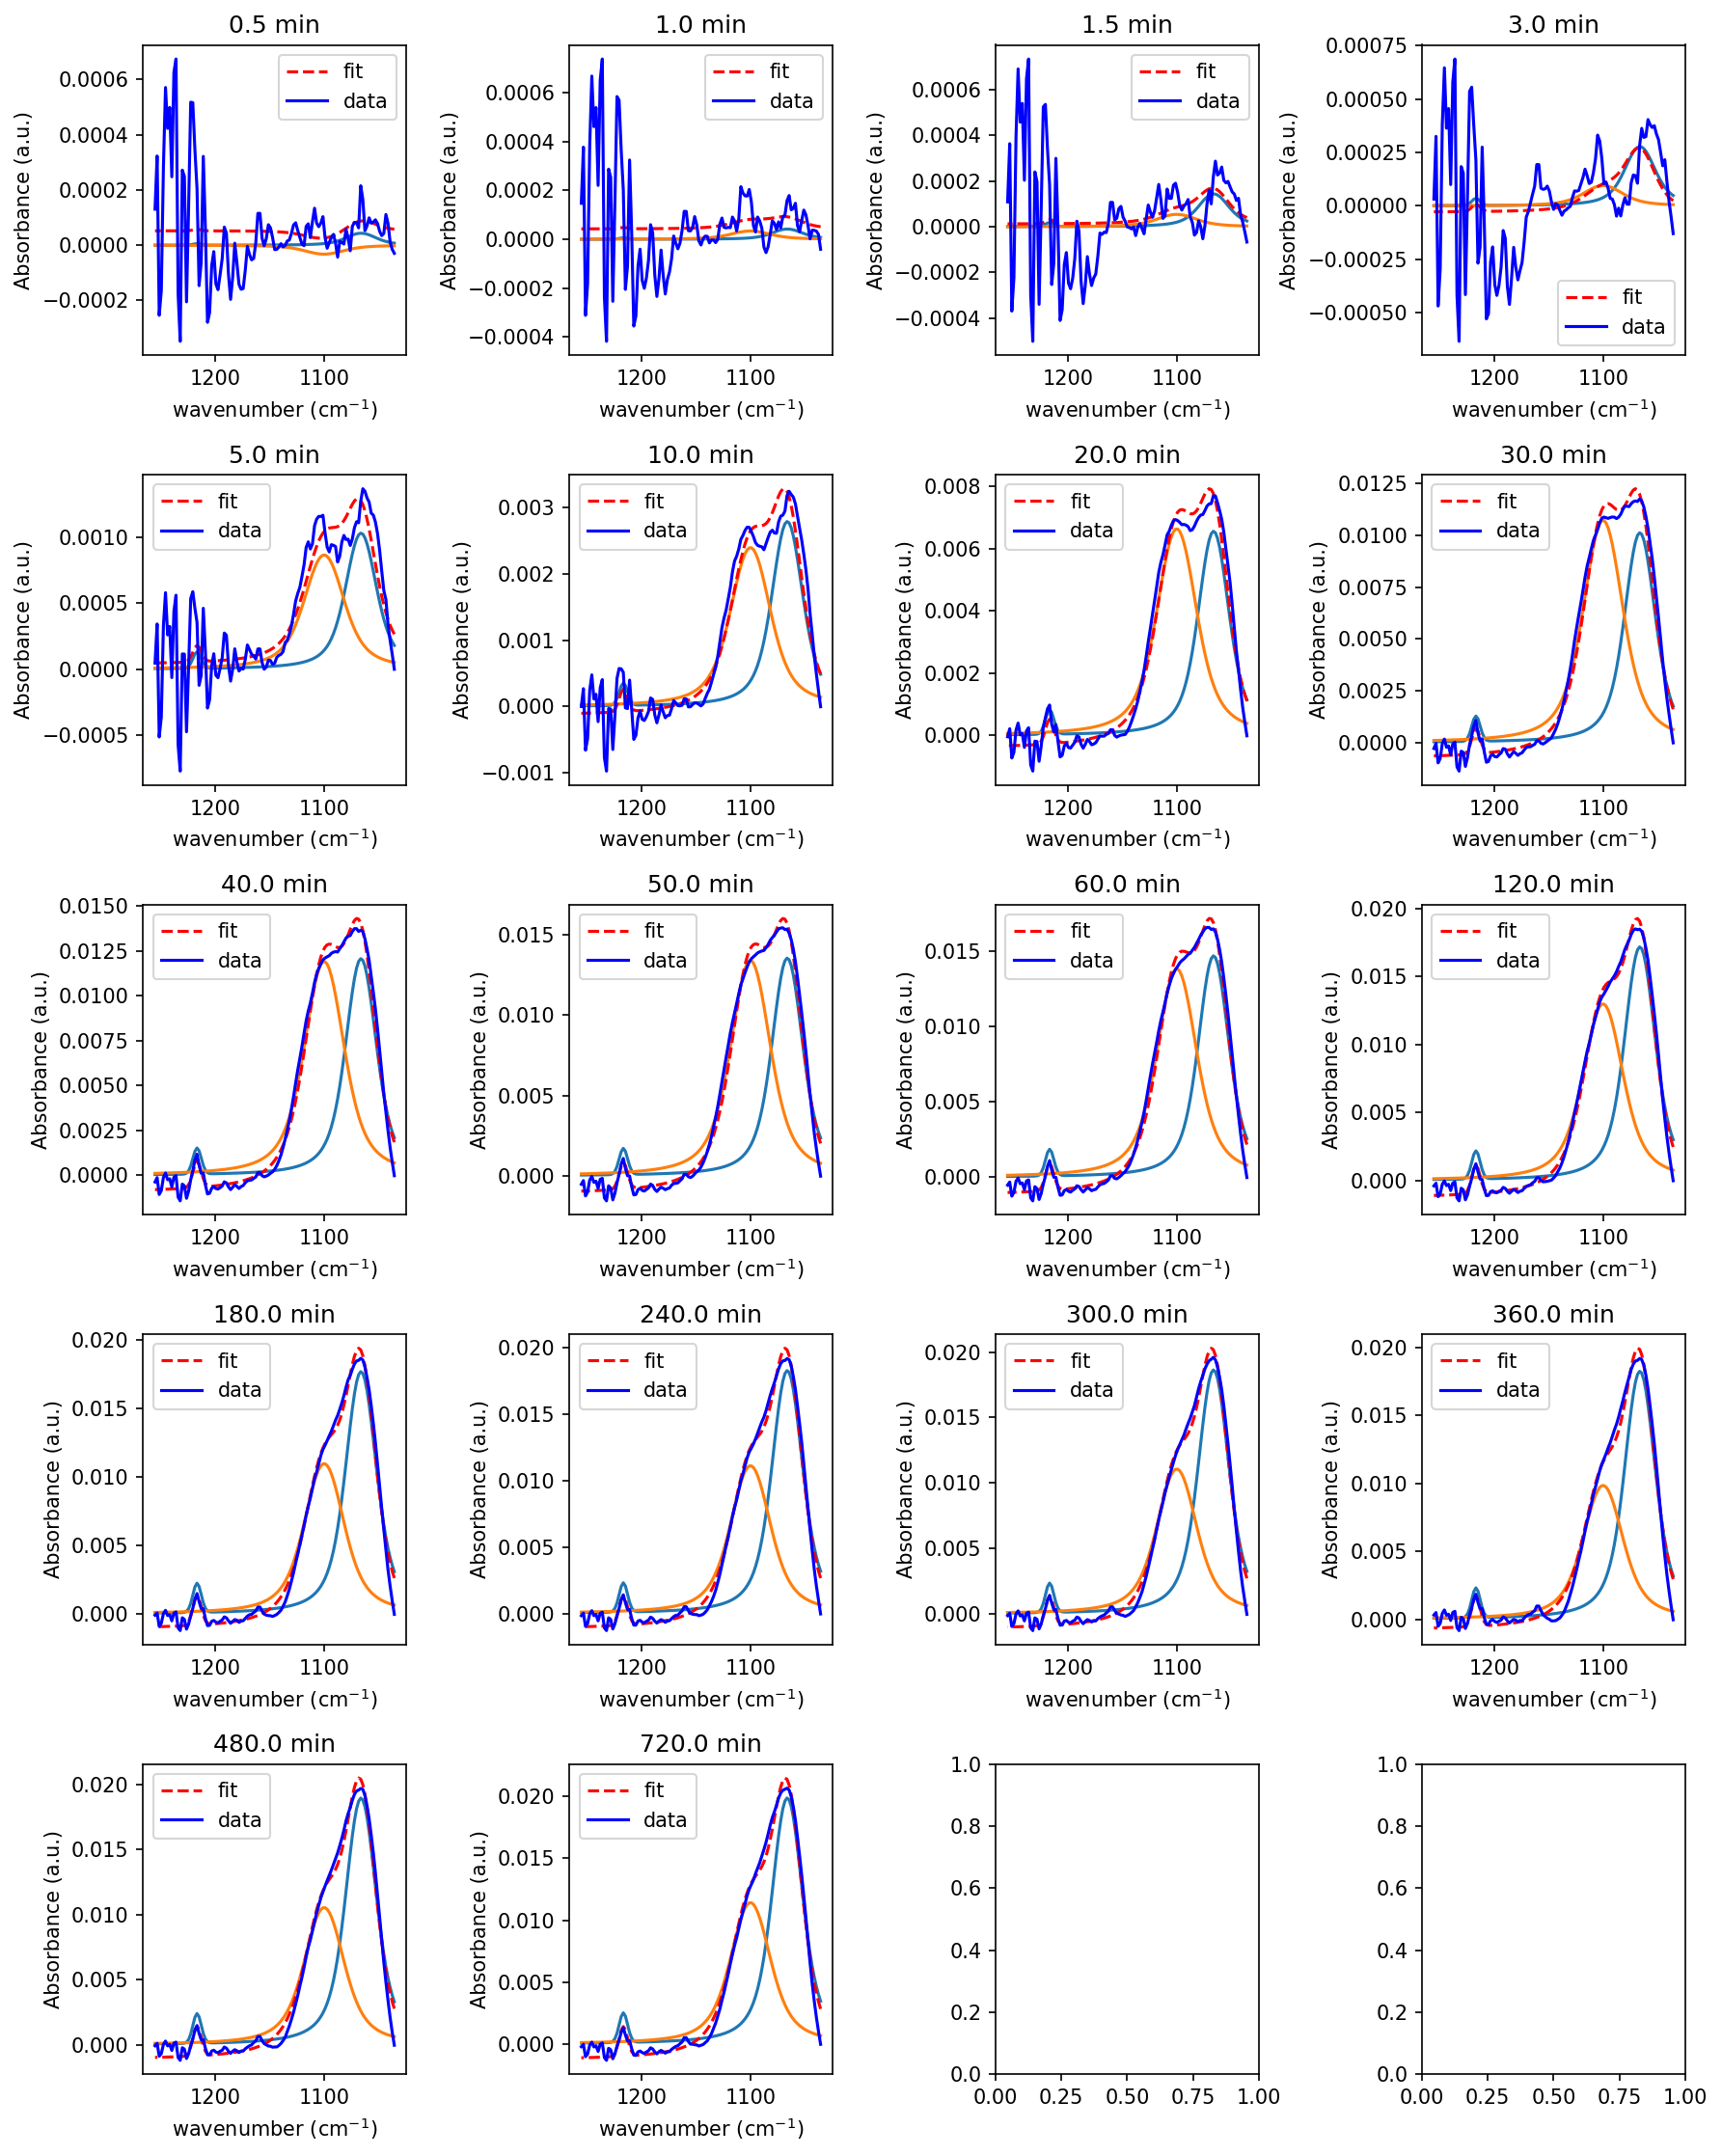

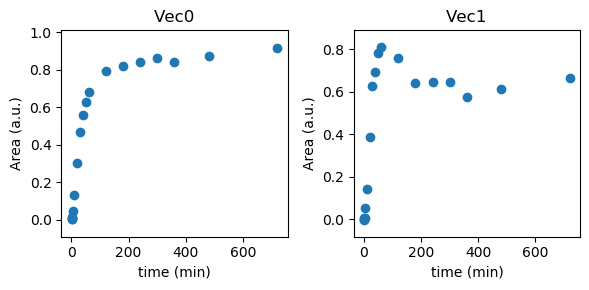

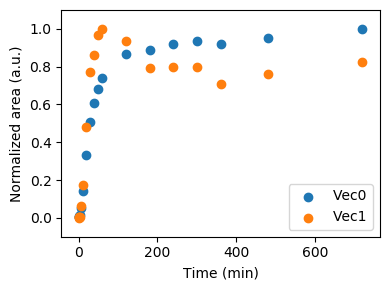

In [146]:
Plot_data(new_params_CO,x_CO,y_CO,Vec_fit_CO,time_CH[:18],False)

In [152]:
def Print_var(Param,Name,Vec,Assignment=None):
    print('Species\t\tType\t\tPeak (cm-1)\terror(%)\tVariance (cm-1)\terror(%)')
    nVec = len(Name)
    data = np.zeros((nVec,len(Time)))
    for j in range(nVec):
        print(Name[j], end='\t')
        nPeak = len(Vec['Peaks'][j])
        for k in range(nPeak):
            if k != 0:
                print('\t',end='\t')
            if Vec['Types'][j][k]:
                print('Voigt', end='\t\t')
            else:
                print('Gaussian', end='\t')
            mu = Param['cen_{}{}{}'.format(0,j,k)].value
            muerror = Param['cen_{}{}{}'.format(0,j,k)].stderr
            sigma = Param['sig_{}{}{}'.format(0,j,k)].value
            sigmaerror = Param['sig_{}{}{}'.format(0,j,k)].stderr
            print('{:.1f}\t\t{}\t\t{:.1f}\t\t{}'.format(mu,muerror,sigma,sigmaerror))
    return None

In [193]:
Vec_IG_struc = {'Peaks':np.array([[0,1,2,3]]),'Types':np.array([[1,1,1,1 ]])}
Print_var(new_params,np.array(['Formates']),Vec_IG_struc)


Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Formates	Voigt		2827.9		None		8.0		None
		Voigt		2951.8		None		1.8		None
		Voigt		2847.0		None		4.5		None
		Voigt		2933.8		None		2.7		None


In [153]:
for i in range(3):
    Print_var(Param_com['Params'][i],np.array(['Carbonyls','Carbonates','Aromatics','Formates','Gas CH4\t']),Vec_IG_CC0)

Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1598.4		None		20.0		None
Carbonates	Gaussian	1545.1		None		5.4		None
		Voigt		1554.6		None		17.8		None
Aromatics	Voigt		1510.2		None		17.9		None
		Voigt		1449.5		None		38.2		None
		Voigt		1332.4		None		23.1		None
Formates	Gaussian	1371.5		None		2.3		None
		Gaussian	1357.6		None		4.9		None
Gas CH4		Gaussian	1303.1		None		2.3		None
Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1603.0		None		20.8		None
Carbonates	Gaussian	1544.0		None		4.6		None
		Voigt		1550.5		None		16.6		None
Aromatics	Voigt		1500.6		None		25.0		None
		Voigt		1421.5		None		38.2		None
		Voigt		1331.0		None		16.9		None
Formates	Gaussian	1370.8		None		1.6		None
		Gaussian	1357.5		None		5.1		None
Gas CH4		Gaussian	1307.9		None		7.6		None
Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1630.6		None		20.0		None
Carbonates	Gaussian	1544.1		None		6.2		None
		Voigt		1565.0		None		13.5		None

In [155]:
Print_var(new_params_CO,np.array(['Alkoxy\t','Alkoxy2\t']),Vec_IG_struc_CO)

Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Alkoxy		Gaussian	1216.8		0.22602579926889768		3.8		0.2353236063756372
		Voigt		1066.2		0.1414113184493949		9.4		0.08368323264199697
Alkoxy2		Voigt		1100.1		0.2802575509058611		12.2		0.15849132321916498
